In [1]:
import numpy as np
import tensorflow as tf
#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


2023-11-29 23:08:37.871528: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
#from u_interpolate_small import regrid_irregular_quick
from datetime import date
import u_interpolate_small as uint
from ndays import numOfDays
import glob
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import pickle 
import calendar

In [3]:
# Define domain and time period
start_lat = 12 # 5 
end_lat = 17 #10
start_lon = -17 #-10
end_lon = -12 #0
start_year = '2010'
start_month = '06'
end_year = '2012'
end_month = '09'
start_day = '01'
end_day = '30'

# find ndays
date1 = date(int(start_year), int(start_month), int(start_day))
date2 = date(int(end_year), int(end_month), int(end_day))
t = numOfDays(date1, date2)+1

# define a regular lat/lon grid close to MSG native resolution (0.04 deg)
#reg_lat = np.arange(start_lat, end_lat, 0.04)
#reg_lon = np.arange(start_lon, end_lon, 0.04) 

In [4]:
# get native MSG grid (core)
coords_filename= './nxny1640_580_nxnyds164580_blobdx0.04491576_area4_n23_20_32.nc'#[0]  # this is /prj/Africa_cloud/geoloc/*.npz on the Linux system
msg_file = xr.open_dataset(coords_filename).squeeze() # pick any convective core file from ch9_wavelet. 
mlon = msg_file['lons_mid'].values
mlat = msg_file['lats_mid'].values


In [5]:
# find core indices using one file
lat_ind = np.where((mlat[:,1]>=start_lat) & (mlat[:,1]<=end_lat))[0]
lon_ind = np.where((mlon[1,:]>=start_lon) & (mlon[1,:]<=end_lon))[0]
lat = mlat[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
lon = mlon[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
#lon = lon_fl[(lon_fl>= start_lon) & (lon_fl<=end_lon)]
#X, Y = np.meshgrid(lon,lat)


#### change t multiplicative factor based on hourly vs 15min data
cores = np.zeros((t*24,len(lat[:,1]),len(lon[1,:])),dtype=float) #using every fourth value for hourly comparison- 24hr
tir = np.zeros((t*24,len(lat[:,1]),len(lon[1,:])),dtype=float) #using every fourth value for hourly comparison- 24hr
time_core = np.zeros((t*24)) #using every fourth value for hourly comparison- 24hr

In [261]:
# read in cores data
list_of_file_names = []

if int(start_year)==int(end_year): 
    for m in range(int(start_month),int(end_month)+1,1): # 1 to include the end month
        if m<10:
            month = str(m).zfill(2)
        else:
            month = str(m)  
        for d in range(1,calendar.monthrange(int(start_year), m)[1]+1,1): # 1 to include the end month
            if d<10:
                day = str(d).zfill(2)
            else:
                day = str(d)  
            #core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
            dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
            all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*00.nc"));
            list_of_file_names.append(all_file_names) # all days in month
        #if os.path.isfile(all_file_names):      
         #   list_of_file_names.append(all_file_names) # all days in month
        #else:
         #   list_of_file_names.append('file_not_available') # all days in month
            #print(all_file_names)
elif int(start_year)<int(end_year):
   # y=1
    for i in range(int(start_year),int(end_year)+1,1):
       # if y==1:
            for m in range(int(start_month),int(end_month)+1,1):
                if m<10:
                    month = str(m).zfill(2)
                else:
                    month = str(m)  
                for d in range(1,calendar.monthrange(i, m)[1]+1,1):
                #for d in range(1,30,1): # 1 to include the end month
                    if d<10:
                        day = str(d).zfill(2)
                    else:
                        day = str(d)  
            #core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
                    dir_name = '/prj/nflics/hist_cores/'+str(i)+'/'+month+'/'+day+'/'
                    all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*00.nc"));
                    list_of_file_names.append(all_file_names) # all days in month
            #print((all_file_names))
                #print(len(all_file_names))
             #   y=y+1
                month=[]
            
      #  else:
        #    for m in range(1,int(end_month)+1,1):
        #        if m<10:
         #           month = str(m).zfill(2)
        #        else:
        #            month = str(m)    
        #        for d in range(1,calendar.monthrange(i, m)[1]+1,1):
        #            if d<10:
        #                day = str(d).zfill(2)
         #           else:
         #               day = str(d)  
         #           dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
        #            all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*00.nc"));
         #           list_of_file_names.append(all_file_names) # all days in month
                  
list_of_files=[]                
for a in range(0,len(list_of_file_names),1):
    list_of_files = list_of_files+list_of_file_names[a]
#if int(start_year)<int(end_year):
 #   list_of_files = list_of_files[0]+list_of_files[1]
#else:
   # list_of_files = list_of_files[0]#+list_of_files[1]    
print(len(list_of_files))

8778


In [ ]:
for l in range(0,len(list_of_files),1):#, min(t*96,len(list_of_files)), 4):#range(len(list_of_files)): # 96 files per day
    core_filename = list_of_files[l]#'/prj/Africa_cloud/ch9_wavelet/'+str(i)+'/'+month+'/'  list_of_files[l]
    print(core_filename)
    #if os.path.isfile(all_file_names):      
    ds = xr.open_dataset(core_filename).squeeze() 
    print(l)
    core_temp = ds['msg_cores'].values
    cores[l,:,:] = core_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
    #uint.interpolate_data(ds['cores'].values, inds, weights, shape) # interpolation using saved weights for MSG cores       
    tir_temp =  ds['msg_Tir'].values/10000
    tir[l,:,:] = tir_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]    
    time_core[l] = str(core_filename[-15:-3])
    #else:
     #   cores[:,:,l] = cores_temp*np.nan  
      #  tir[:,:,l] = tir_temp*np.nan   
       # time_core[l] = (core_filename[-15:-3])
  

/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010000.nc
0
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010100.nc
1
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010200.nc
2
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010300.nc
3
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010400.nc
4
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010500.nc
5
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010600.nc
6
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010700.nc
7
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010800.nc
8
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010900.nc
9
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006011000.nc
10
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006011100.nc
11
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006011200.nc
12
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006011300.nc
13
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006011400.nc
14
/prj/

122
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060300.nc
123
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060400.nc
124
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060500.nc
125
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060600.nc
126
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060700.nc
127
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060800.nc
128
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060900.nc
129
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061000.nc
130
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061100.nc
131
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061200.nc
132
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061300.nc
133
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061400.nc
134
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061500.nc
135
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061600.nc
136
/prj/nflics/hist_cores/2010/06/06/Hist_cores

245
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110600.nc
246
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110700.nc
247
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110800.nc
248
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110900.nc
249
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111000.nc
250
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111100.nc
251
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111200.nc
252
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111300.nc
253
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111400.nc
254
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111500.nc
255
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111600.nc
256
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111700.nc
257
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111800.nc
258
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111900.nc
259
/prj/nflics/hist_cores/2010/06/11/Hist_cores

/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160700.nc
367
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160800.nc
368
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160900.nc
369
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161000.nc
370
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161100.nc
371
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161200.nc
372
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161300.nc
373
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161400.nc
374
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161500.nc
375
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161600.nc
376
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161700.nc
377
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161800.nc
378
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161900.nc
379
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006162000.nc
380
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_

487
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210800.nc
488
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210900.nc
489
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211000.nc
490
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211100.nc
491
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211200.nc
492
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211300.nc
493
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211400.nc
494
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211500.nc
495
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211600.nc
496
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211700.nc
497
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211800.nc
498
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211900.nc
499
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006212000.nc
500
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006212100.nc
501
/prj/nflics/hist_cores/2010/06/21/Hist_cores

610
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261100.nc
611
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261200.nc
612
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261300.nc
613
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261400.nc
614
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261500.nc
615
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261600.nc
616
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261700.nc
617
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261800.nc
618
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261900.nc
619
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006262000.nc
620
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006262100.nc
621
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006262200.nc
622
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006262300.nc
623
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006270000.nc
624
/prj/nflics/hist_cores/2010/06/27/Hist_cores

731
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011200.nc
732
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011300.nc
733
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011400.nc
734
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011500.nc
735
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011600.nc
736
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011700.nc
737
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011800.nc
738
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011900.nc
739
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007012000.nc
740
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007012100.nc
741
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007012200.nc
742
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007012300.nc
743
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020000.nc
744
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020100.nc
745
/prj/nflics/hist_cores/2010/07/02/Hist_cores

853
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061400.nc
854
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061500.nc
855
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061600.nc
856
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061700.nc
857
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061800.nc
858
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061900.nc
859
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007062000.nc
860
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007062100.nc
861
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007062200.nc
862
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007062300.nc
863
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070000.nc
864
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070100.nc
865
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070200.nc
866
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070300.nc
867
/prj/nflics/hist_cores/2010/07/07/Hist_cores

974
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007111500.nc
975
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007111600.nc
976
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007111700.nc
977
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007111800.nc
978
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007111900.nc
979
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007112000.nc
980
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007112100.nc
981
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007112200.nc
982
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007112300.nc
983
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120000.nc
984
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120100.nc
985
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120200.nc
986
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120300.nc
987
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120400.nc
988
/prj/nflics/hist_cores/2010/07/12/Hist_cores

1094
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007161500.nc
1095
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007161600.nc
1096
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007161700.nc
1097
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007161800.nc
1098
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007161900.nc
1099
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007162000.nc
1100
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007162100.nc
1101
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007162200.nc
1102
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007162300.nc
1103
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170000.nc
1104
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170100.nc
1105
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170200.nc
1106
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170300.nc
1107
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170400.nc
1108
/prj/nflics/hist_cores/2010/0

1213
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007211400.nc
1214
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007211500.nc
1215
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007211600.nc
1216
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007211700.nc
1217
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007211800.nc
1218
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007211900.nc
1219
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007212000.nc
1220
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007212100.nc
1221
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007212200.nc
1222
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007212300.nc
1223
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220000.nc
1224
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220100.nc
1225
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220200.nc
1226
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220300.nc
1227
/prj/nflics/hist_cores/2010/0

1332
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261300.nc
1333
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261400.nc
1334
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261500.nc
1335
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261600.nc
1336
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261700.nc
1337
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261800.nc
1338
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261900.nc
1339
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007262000.nc
1340
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007262100.nc
1341
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007262200.nc
1342
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007262300.nc
1343
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270000.nc
1344
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270100.nc
1345
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270200.nc
1346
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311300.nc
1453
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311400.nc
1454
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311500.nc
1455
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311600.nc
1456
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311700.nc
1457
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311800.nc
1458
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311900.nc
1459
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007312000.nc
1460
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007312100.nc
1461
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007312200.nc
1462
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007312300.nc
1463
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010000.nc
1464
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010100.nc
1465
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010200.nc
1466
/prj/nflics/hist_cores/2010/08/01/

/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051300.nc
1573
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051400.nc
1574
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051500.nc
1575
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051600.nc
1576
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051700.nc
1577
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051800.nc
1578
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051900.nc
1579
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008052000.nc
1580
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008052100.nc
1581
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008052200.nc
1582
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008052300.nc
1583
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060000.nc
1584
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060100.nc
1585
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060200.nc
1586
/prj/nflics/hist_cores/2010/08/06/

1691
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101200.nc
1692
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101300.nc
1693
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101400.nc
1694
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101500.nc
1695
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101600.nc
1696
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101700.nc
1697
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101800.nc
1698
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101900.nc
1699
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008102000.nc
1700
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008102100.nc
1701
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008102200.nc
1702
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008102300.nc
1703
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110000.nc
1704
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110100.nc
1705
/prj/nflics/hist_cores/2010/0

1811
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151200.nc
1812
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151300.nc
1813
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151400.nc
1814
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151500.nc
1815
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151600.nc
1816
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151700.nc
1817
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151800.nc
1818
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151900.nc
1819
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008152000.nc
1820
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008152100.nc
1821
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008152200.nc
1822
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008152300.nc
1823
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160000.nc
1824
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160100.nc
1825
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201100.nc
1931
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201200.nc
1932
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201300.nc
1933
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201400.nc
1934
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201500.nc
1935
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201600.nc
1936
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201700.nc
1937
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201800.nc
1938
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201900.nc
1939
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008202000.nc
1940
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008202100.nc
1941
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008202200.nc
1942
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008202300.nc
1943
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210000.nc
1944
/prj/nflics/hist_cores/2010/08/21/

2049
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251000.nc
2050
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251100.nc
2051
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251200.nc
2052
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251300.nc
2053
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251400.nc
2054
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251500.nc
2055
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251600.nc
2056
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251700.nc
2057
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251800.nc
2058
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251900.nc
2059
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008252000.nc
2060
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008252100.nc
2061
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008252200.nc
2062
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008252300.nc
2063
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301000.nc
2170
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301100.nc
2171
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301200.nc
2172
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301300.nc
2173
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301400.nc
2174
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301500.nc
2175
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301600.nc
2176
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301700.nc
2177
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301800.nc
2178
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301900.nc
2179
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008302000.nc
2180
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008302100.nc
2181
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008302200.nc
2182
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008302300.nc
2183
/prj/nflics/hist_cores/2010/08/31/

2288
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040900.nc
2289
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041000.nc
2290
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041100.nc
2291
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041200.nc
2292
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041300.nc
2293
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041400.nc
2294
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041500.nc
2295
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041600.nc
2296
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041700.nc
2297
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041800.nc
2298
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041900.nc
2299
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009042000.nc
2300
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009042100.nc
2301
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009042200.nc
2302
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090800.nc
2408
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090900.nc
2409
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091000.nc
2410
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091100.nc
2411
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091200.nc
2412
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091300.nc
2413
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091400.nc
2414
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091500.nc
2415
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091600.nc
2416
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091700.nc
2417
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091800.nc
2418
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091900.nc
2419
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009092000.nc
2420
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009092100.nc
2421
/prj/nflics/hist_cores/2010/09/09/

2528
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140900.nc
2529
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141000.nc
2530
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141100.nc
2531
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141200.nc
2532
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141300.nc
2533
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141400.nc
2534
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141500.nc
2535
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141600.nc
2536
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141700.nc
2537
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141800.nc
2538
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141900.nc
2539
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009142000.nc
2540
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009142100.nc
2541
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009142200.nc
2542
/prj/nflics/hist_cores/2010/0

2647
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009190800.nc
2648
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009190900.nc
2649
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191000.nc
2650
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191100.nc
2651
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191200.nc
2652
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191300.nc
2653
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191400.nc
2654
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191500.nc
2655
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191600.nc
2656
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191700.nc
2657
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191800.nc
2658
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191900.nc
2659
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009192000.nc
2660
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009192100.nc
2661
/prj/nflics/hist_cores/2010/0

2766
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009240700.nc
2767
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009240800.nc
2768
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009240900.nc
2769
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241000.nc
2770
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241100.nc
2771
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241200.nc
2772
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241300.nc
2773
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241400.nc
2774
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241500.nc
2775
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241600.nc
2776
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241700.nc
2777
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241800.nc
2778
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241900.nc
2779
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009242000.nc
2780
/prj/nflics/hist_cores/2010/0

2886
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009290700.nc
2887
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009290800.nc
2888
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009290900.nc
2889
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291000.nc
2890
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291100.nc
2891
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291200.nc
2892
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291300.nc
2893
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291400.nc
2894
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291500.nc
2895
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291600.nc
2896
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291700.nc
2897
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291800.nc
2898
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291900.nc
2899
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009292000.nc
2900
/prj/nflics/hist_cores/2010/0

3006
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106040700.nc
3007
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106040800.nc
3008
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106040900.nc
3009
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041000.nc
3010
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041100.nc
3011
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041200.nc
3012
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041300.nc
3013
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041400.nc
3014
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041500.nc
3015
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041600.nc
3016
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041700.nc
3017
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041800.nc
3018
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041900.nc
3019
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106042000.nc
3020
/prj/nflics/hist_cores/2011/0

3127
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106090800.nc
3128
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106090900.nc
3129
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091000.nc
3130
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091100.nc
3131
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091200.nc
3132
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091300.nc
3133
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091400.nc
3134
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091500.nc
3135
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091600.nc
3136
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091700.nc
3137
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091800.nc
3138
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091900.nc
3139
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106092000.nc
3140
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106092100.nc
3141
/prj/nflics/hist_cores/2011/0

3247
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106140800.nc
3248
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106140900.nc
3249
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141000.nc
3250
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141100.nc
3251
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141200.nc
3252
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141300.nc
3253
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141400.nc
3254
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141500.nc
3255
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141600.nc
3256
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141700.nc
3257
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141800.nc
3258
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141900.nc
3259
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106142000.nc
3260
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106142100.nc
3261
/prj/nflics/hist_cores/2011/0

3366
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106190700.nc
3367
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106190800.nc
3368
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106190900.nc
3369
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106191000.nc
3370
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106191100.nc
3371
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106191200.nc
3372
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106191300.nc
3373
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106191400.nc
3374
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106191500.nc
3375
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106191600.nc
3376
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106191700.nc
3377
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106191800.nc
3378
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106191900.nc
3379
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106192000.nc
3380
/prj/nflics/hist_cores/2011/0

3487
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106240800.nc
3488
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106240900.nc
3489
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106241000.nc
3490
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106241100.nc
3491
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106241200.nc
3492
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106241300.nc
3493
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106241400.nc
3494
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106241500.nc
3495
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106241600.nc
3496
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106241700.nc
3497
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106241800.nc
3498
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106241900.nc
3499
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106242000.nc
3500
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106242100.nc
3501
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106290700.nc
3607
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106290800.nc
3608
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106290900.nc
3609
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106291000.nc
3610
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106291100.nc
3611
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106291200.nc
3612
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106291300.nc
3613
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106291400.nc
3614
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106291500.nc
3615
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106291600.nc
3616
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106291700.nc
3617
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106291800.nc
3618
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106291900.nc
3619
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106292000.nc
3620
/prj/nflics/hist_cores/2011/06/29/

/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107040700.nc
3727
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107040800.nc
3728
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107040900.nc
3729
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107041000.nc
3730
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107041100.nc
3731
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107041200.nc
3732
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107041300.nc
3733
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107041400.nc
3734
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107041500.nc
3735
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107041600.nc
3736
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107041700.nc
3737
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107041800.nc
3738
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107041900.nc
3739
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107042000.nc
3740
/prj/nflics/hist_cores/2011/07/04/

/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107090600.nc
3846
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107090700.nc
3847
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107090800.nc
3848
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107090900.nc
3849
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107091000.nc
3850
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107091100.nc
3851
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107091200.nc
3852
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107091300.nc
3853
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107091400.nc
3854
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107091500.nc
3855
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107091600.nc
3856
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107091700.nc
3857
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107091800.nc
3858
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107091900.nc
3859
/prj/nflics/hist_cores/2011/07/09/

3964
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107140500.nc
3965
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107140600.nc
3966
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107140700.nc
3967
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107140800.nc
3968
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107140900.nc
3969
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107141000.nc
3970
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107141100.nc
3971
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107141200.nc
3972
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107141300.nc
3973
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107141400.nc
3974
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107141500.nc
3975
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107141600.nc
3976
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107141700.nc
3977
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107141800.nc
3978
/prj/nflics/hist_cores/2011/0

4083
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107190400.nc
4084
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107190500.nc
4085
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107190600.nc
4086
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107190700.nc
4087
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107190800.nc
4088
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107190900.nc
4089
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191000.nc
4090
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191100.nc
4091
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191200.nc
4092
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191300.nc
4093
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191400.nc
4094
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191500.nc
4095
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191600.nc
4096
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191700.nc
4097
/prj/nflics/hist_cores/2011/0

4202
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107240300.nc
4203
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107240400.nc
4204
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107240500.nc
4205
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107240600.nc
4206
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107240700.nc
4207
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107240800.nc
4208
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107240900.nc
4209
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241000.nc
4210
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241100.nc
4211
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241200.nc
4212
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241300.nc
4213
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241400.nc
4214
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241500.nc
4215
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241600.nc
4216
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107290300.nc
4323
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107290400.nc
4324
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107290500.nc
4325
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107290600.nc
4326
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107290700.nc
4327
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107290800.nc
4328
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107290900.nc
4329
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291000.nc
4330
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291100.nc
4331
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291200.nc
4332
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291300.nc
4333
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291400.nc
4334
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291500.nc
4335
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291600.nc
4336
/prj/nflics/hist_cores/2011/07/29/

/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108030200.nc
4442
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108030300.nc
4443
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108030400.nc
4444
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108030500.nc
4445
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108030600.nc
4446
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108030700.nc
4447
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108030800.nc
4448
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108030900.nc
4449
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031000.nc
4450
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031100.nc
4451
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031200.nc
4452
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031300.nc
4453
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031400.nc
4454
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031500.nc
4455
/prj/nflics/hist_cores/2011/08/03/

4561
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108080200.nc
4562
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108080300.nc
4563
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108080400.nc
4564
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108080500.nc
4565
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108080600.nc
4566
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108080700.nc
4567
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108080800.nc
4568
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108080900.nc
4569
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081000.nc
4570
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081100.nc
4571
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081200.nc
4572
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081300.nc
4573
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081400.nc
4574
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081500.nc
4575
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108130200.nc
4682
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108130300.nc
4683
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108130400.nc
4684
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108130500.nc
4685
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108130600.nc
4686
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108130700.nc
4687
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108130800.nc
4688
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108130900.nc
4689
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131000.nc
4690
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131100.nc
4691
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131200.nc
4692
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131300.nc
4693
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131400.nc
4694
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131500.nc
4695
/prj/nflics/hist_cores/2011/08/13/

/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108180100.nc
4801
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108180200.nc
4802
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108180300.nc
4803
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108180400.nc
4804
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108180500.nc
4805
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108180600.nc
4806
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108180700.nc
4807
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108180800.nc
4808
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108180900.nc
4809
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181000.nc
4810
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181100.nc
4811
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181200.nc
4812
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181300.nc
4813
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181400.nc
4814
/prj/nflics/hist_cores/2011/08/18/

4919
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108230000.nc
4920
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108230100.nc
4921
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108230200.nc
4922
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108230300.nc
4923
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108230400.nc
4924
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108230500.nc
4925
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108230600.nc
4926
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108230700.nc
4927
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108230800.nc
4928
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108230900.nc
4929
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108231000.nc
4930
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108231100.nc
4931
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108231200.nc
4932
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108231300.nc
4933
/prj/nflics/hist_cores/2011/0

5038
/prj/nflics/hist_cores/2011/08/27/Hist_cores_wa_201108272300.nc
5039
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108280000.nc
5040
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108280100.nc
5041
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108280200.nc
5042
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108280300.nc
5043
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108280400.nc
5044
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108280500.nc
5045
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108280600.nc
5046
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108280700.nc
5047
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108280800.nc
5048
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108280900.nc
5049
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108281000.nc
5050
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108281100.nc
5051
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108281200.nc
5052
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109012200.nc
5158
/prj/nflics/hist_cores/2011/09/01/Hist_cores_wa_201109012300.nc
5159
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109020000.nc
5160
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109020100.nc
5161
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109020200.nc
5162
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109020300.nc
5163
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109020400.nc
5164
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109020500.nc
5165
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109020600.nc
5166
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109020700.nc
5167
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109020800.nc
5168
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109020900.nc
5169
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109021000.nc
5170
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109021100.nc
5171
/prj/nflics/hist_cores/2011/09/02/

/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109062100.nc
5277
/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109062200.nc
5278
/prj/nflics/hist_cores/2011/09/06/Hist_cores_wa_201109062300.nc
5279
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109070000.nc
5280
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109070100.nc
5281
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109070200.nc
5282
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109070300.nc
5283
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109070400.nc
5284
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109070500.nc
5285
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109070600.nc
5286
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109070700.nc
5287
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109070800.nc
5288
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109070900.nc
5289
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109071000.nc
5290
/prj/nflics/hist_cores/2011/09/07/

5397
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109112200.nc
5398
/prj/nflics/hist_cores/2011/09/11/Hist_cores_wa_201109112300.nc
5399
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109120000.nc
5400
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109120100.nc
5401
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109120200.nc
5402
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109120300.nc
5403
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109120400.nc
5404
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109120500.nc
5405
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109120600.nc
5406
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109120700.nc
5407
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109120800.nc
5408
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109120900.nc
5409
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109121000.nc
5410
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109121100.nc
5411
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109162200.nc
5518
/prj/nflics/hist_cores/2011/09/16/Hist_cores_wa_201109162300.nc
5519
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109170000.nc
5520
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109170100.nc
5521
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109170200.nc
5522
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109170300.nc
5523
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109170400.nc
5524
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109170500.nc
5525
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109170600.nc
5526
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109170700.nc
5527
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109170800.nc
5528
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109170900.nc
5529
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109171000.nc
5530
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109171100.nc
5531
/prj/nflics/hist_cores/2011/09/17/

5636
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109212100.nc
5637
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109212200.nc
5638
/prj/nflics/hist_cores/2011/09/21/Hist_cores_wa_201109212300.nc
5639
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109220000.nc
5640
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109220100.nc
5641
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109220200.nc
5642
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109220300.nc
5643
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109220400.nc
5644
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109220500.nc
5645
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109220600.nc
5646
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109220700.nc
5647
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109220800.nc
5648
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109220900.nc
5649
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109221000.nc
5650
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109262100.nc
5757
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109262200.nc
5758
/prj/nflics/hist_cores/2011/09/26/Hist_cores_wa_201109262300.nc
5759
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109270000.nc
5760
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109270100.nc
5761
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109270200.nc
5762
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109270300.nc
5763
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109270400.nc
5764
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109270500.nc
5765
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109270600.nc
5766
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109270700.nc
5767
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109270800.nc
5768
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109270900.nc
5769
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109271000.nc
5770
/prj/nflics/hist_cores/2011/09/27/

5877
/prj/nflics/hist_cores/2012/06/01/Hist_cores_wa_201206012200.nc
5878
/prj/nflics/hist_cores/2012/06/01/Hist_cores_wa_201206012300.nc
5879
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206020000.nc
5880
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206020100.nc
5881
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206020200.nc
5882
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206020300.nc
5883
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206020400.nc
5884
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206020500.nc
5885
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206020600.nc
5886
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206020700.nc
5887
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206020800.nc
5888
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206020900.nc
5889
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206021000.nc
5890
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206021100.nc
5891
/prj/nflics/hist_cores/2012/0

5997
/prj/nflics/hist_cores/2012/06/06/Hist_cores_wa_201206062200.nc
5998
/prj/nflics/hist_cores/2012/06/06/Hist_cores_wa_201206062300.nc
5999
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206070000.nc
6000
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206070100.nc
6001
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206070200.nc
6002
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206070300.nc
6003
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206070400.nc
6004
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206070500.nc
6005
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206070600.nc
6006
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206070700.nc
6007
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206070800.nc
6008
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206070900.nc
6009
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206071000.nc
6010
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206071100.nc
6011
/prj/nflics/hist_cores/2012/0

6117
/prj/nflics/hist_cores/2012/06/11/Hist_cores_wa_201206112200.nc
6118
/prj/nflics/hist_cores/2012/06/11/Hist_cores_wa_201206112300.nc
6119
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206120000.nc
6120
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206120100.nc
6121
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206120200.nc
6122
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206120300.nc
6123
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206120400.nc
6124
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206120500.nc
6125
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206120600.nc
6126
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206120700.nc
6127
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206120800.nc
6128
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206120900.nc
6129
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206121000.nc
6130
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206121100.nc
6131
/prj/nflics/hist_cores/2012/0

6236
/prj/nflics/hist_cores/2012/06/16/Hist_cores_wa_201206162100.nc
6237
/prj/nflics/hist_cores/2012/06/16/Hist_cores_wa_201206162200.nc
6238
/prj/nflics/hist_cores/2012/06/16/Hist_cores_wa_201206162300.nc
6239
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206170000.nc
6240
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206170100.nc
6241
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206170200.nc
6242
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206170300.nc
6243
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206170400.nc
6244
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206170500.nc
6245
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206170600.nc
6246
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206170700.nc
6247
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206170800.nc
6248
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206170900.nc
6249
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206171000.nc
6250
/prj/nflics/hist_cores/2012/0

/prj/nflics/hist_cores/2012/06/21/Hist_cores_wa_201206212000.nc
6356
/prj/nflics/hist_cores/2012/06/21/Hist_cores_wa_201206212100.nc
6357
/prj/nflics/hist_cores/2012/06/21/Hist_cores_wa_201206212200.nc
6358
/prj/nflics/hist_cores/2012/06/21/Hist_cores_wa_201206212300.nc
6359
/prj/nflics/hist_cores/2012/06/22/Hist_cores_wa_201206220000.nc
6360
/prj/nflics/hist_cores/2012/06/22/Hist_cores_wa_201206220100.nc
6361
/prj/nflics/hist_cores/2012/06/22/Hist_cores_wa_201206220200.nc
6362
/prj/nflics/hist_cores/2012/06/22/Hist_cores_wa_201206220300.nc
6363
/prj/nflics/hist_cores/2012/06/22/Hist_cores_wa_201206220400.nc
6364
/prj/nflics/hist_cores/2012/06/22/Hist_cores_wa_201206220500.nc
6365
/prj/nflics/hist_cores/2012/06/22/Hist_cores_wa_201206220600.nc
6366
/prj/nflics/hist_cores/2012/06/22/Hist_cores_wa_201206220700.nc
6367
/prj/nflics/hist_cores/2012/06/22/Hist_cores_wa_201206220800.nc
6368
/prj/nflics/hist_cores/2012/06/22/Hist_cores_wa_201206220900.nc
6369
/prj/nflics/hist_cores/2012/06/22/

6476
/prj/nflics/hist_cores/2012/06/26/Hist_cores_wa_201206262100.nc
6477
/prj/nflics/hist_cores/2012/06/26/Hist_cores_wa_201206262200.nc
6478
/prj/nflics/hist_cores/2012/06/26/Hist_cores_wa_201206262300.nc
6479
/prj/nflics/hist_cores/2012/06/27/Hist_cores_wa_201206270000.nc
6480
/prj/nflics/hist_cores/2012/06/27/Hist_cores_wa_201206270100.nc
6481
/prj/nflics/hist_cores/2012/06/27/Hist_cores_wa_201206270200.nc
6482
/prj/nflics/hist_cores/2012/06/27/Hist_cores_wa_201206270300.nc
6483
/prj/nflics/hist_cores/2012/06/27/Hist_cores_wa_201206270400.nc
6484
/prj/nflics/hist_cores/2012/06/27/Hist_cores_wa_201206270500.nc
6485
/prj/nflics/hist_cores/2012/06/27/Hist_cores_wa_201206270600.nc
6486
/prj/nflics/hist_cores/2012/06/27/Hist_cores_wa_201206270700.nc
6487
/prj/nflics/hist_cores/2012/06/27/Hist_cores_wa_201206270800.nc
6488
/prj/nflics/hist_cores/2012/06/27/Hist_cores_wa_201206270900.nc
6489
/prj/nflics/hist_cores/2012/06/27/Hist_cores_wa_201206271000.nc
6490
/prj/nflics/hist_cores/2012/0

6595
/prj/nflics/hist_cores/2012/07/01/Hist_cores_wa_201207012000.nc
6596
/prj/nflics/hist_cores/2012/07/01/Hist_cores_wa_201207012100.nc
6597
/prj/nflics/hist_cores/2012/07/01/Hist_cores_wa_201207012200.nc
6598
/prj/nflics/hist_cores/2012/07/01/Hist_cores_wa_201207012300.nc
6599
/prj/nflics/hist_cores/2012/07/02/Hist_cores_wa_201207020000.nc
6600
/prj/nflics/hist_cores/2012/07/02/Hist_cores_wa_201207020100.nc
6601
/prj/nflics/hist_cores/2012/07/02/Hist_cores_wa_201207020200.nc
6602
/prj/nflics/hist_cores/2012/07/02/Hist_cores_wa_201207020300.nc
6603
/prj/nflics/hist_cores/2012/07/02/Hist_cores_wa_201207020400.nc
6604
/prj/nflics/hist_cores/2012/07/02/Hist_cores_wa_201207020500.nc
6605
/prj/nflics/hist_cores/2012/07/02/Hist_cores_wa_201207020600.nc
6606
/prj/nflics/hist_cores/2012/07/02/Hist_cores_wa_201207020700.nc
6607
/prj/nflics/hist_cores/2012/07/02/Hist_cores_wa_201207020800.nc
6608
/prj/nflics/hist_cores/2012/07/02/Hist_cores_wa_201207020900.nc
6609
/prj/nflics/hist_cores/2012/0

/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207070100.nc
6715
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207070200.nc
6716
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207070300.nc
6717
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207070400.nc
6718
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207070500.nc
6719
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207070600.nc
6720
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207070700.nc
6721
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207070800.nc
6722
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207070900.nc
6723
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207071000.nc
6724
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207071100.nc
6725
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207071200.nc
6726
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207071300.nc
6727
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207071400.nc
6728
/prj/nflics/hist_cores/2012/07/07/

/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207120000.nc
6834
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207120100.nc
6835
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207120200.nc
6836
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207120300.nc
6837
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207120400.nc
6838
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207120500.nc
6839
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207120600.nc
6840
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207120700.nc
6841
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207120800.nc
6842
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207120900.nc
6843
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207121000.nc
6844
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207121100.nc
6845
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207121200.nc
6846
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207121300.nc
6847
/prj/nflics/hist_cores/2012/07/12/

/prj/nflics/hist_cores/2012/07/16/Hist_cores_wa_201207162300.nc
6953
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207170000.nc
6954
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207170100.nc
6955
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207170200.nc
6956
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207170300.nc
6957
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207170400.nc
6958
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207170500.nc
6959
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207170600.nc
6960
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207170700.nc
6961
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207170800.nc
6962
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207170900.nc
6963
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207171000.nc
6964
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207171100.nc
6965
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207171200.nc
6966
/prj/nflics/hist_cores/2012/07/17/

/prj/nflics/hist_cores/2012/07/21/Hist_cores_wa_201207212200.nc
7072
/prj/nflics/hist_cores/2012/07/21/Hist_cores_wa_201207212300.nc
7073
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207220000.nc
7074
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207220100.nc
7075
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207220200.nc
7076
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207220300.nc
7077
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207220400.nc
7078
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207220500.nc
7079
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207220600.nc
7080
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207220700.nc
7081
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207220800.nc
7082
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207220900.nc
7083
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207221000.nc
7084
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207221100.nc
7085
/prj/nflics/hist_cores/2012/07/22/

/prj/nflics/hist_cores/2012/07/26/Hist_cores_wa_201207262100.nc
7191
/prj/nflics/hist_cores/2012/07/26/Hist_cores_wa_201207262200.nc
7192
/prj/nflics/hist_cores/2012/07/26/Hist_cores_wa_201207262300.nc
7193
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207270000.nc
7194
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207270100.nc
7195
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207270200.nc
7196
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207270300.nc
7197
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207270400.nc
7198
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207270500.nc
7199
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207270600.nc
7200
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207270700.nc
7201
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207270800.nc
7202
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207270900.nc
7203
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207271000.nc
7204
/prj/nflics/hist_cores/2012/07/27/

7309
/prj/nflics/hist_cores/2012/07/31/Hist_cores_wa_201207312000.nc
7310
/prj/nflics/hist_cores/2012/07/31/Hist_cores_wa_201207312100.nc
7311
/prj/nflics/hist_cores/2012/07/31/Hist_cores_wa_201207312200.nc
7312
/prj/nflics/hist_cores/2012/07/31/Hist_cores_wa_201207312300.nc
7313
/prj/nflics/hist_cores/2012/08/01/Hist_cores_wa_201208010000.nc
7314
/prj/nflics/hist_cores/2012/08/01/Hist_cores_wa_201208010100.nc
7315
/prj/nflics/hist_cores/2012/08/01/Hist_cores_wa_201208010200.nc
7316
/prj/nflics/hist_cores/2012/08/01/Hist_cores_wa_201208010300.nc
7317
/prj/nflics/hist_cores/2012/08/01/Hist_cores_wa_201208010400.nc
7318
/prj/nflics/hist_cores/2012/08/01/Hist_cores_wa_201208010500.nc
7319
/prj/nflics/hist_cores/2012/08/01/Hist_cores_wa_201208010600.nc
7320
/prj/nflics/hist_cores/2012/08/01/Hist_cores_wa_201208010700.nc
7321
/prj/nflics/hist_cores/2012/08/01/Hist_cores_wa_201208010800.nc
7322
/prj/nflics/hist_cores/2012/08/01/Hist_cores_wa_201208010900.nc
7323
/prj/nflics/hist_cores/2012/0

7428
/prj/nflics/hist_cores/2012/08/05/Hist_cores_wa_201208051900.nc
7429
/prj/nflics/hist_cores/2012/08/05/Hist_cores_wa_201208052000.nc
7430
/prj/nflics/hist_cores/2012/08/05/Hist_cores_wa_201208052100.nc
7431
/prj/nflics/hist_cores/2012/08/05/Hist_cores_wa_201208052200.nc
7432
/prj/nflics/hist_cores/2012/08/05/Hist_cores_wa_201208052300.nc
7433
/prj/nflics/hist_cores/2012/08/06/Hist_cores_wa_201208060000.nc
7434
/prj/nflics/hist_cores/2012/08/06/Hist_cores_wa_201208060100.nc
7435
/prj/nflics/hist_cores/2012/08/06/Hist_cores_wa_201208060200.nc
7436
/prj/nflics/hist_cores/2012/08/06/Hist_cores_wa_201208060300.nc
7437
/prj/nflics/hist_cores/2012/08/06/Hist_cores_wa_201208060400.nc
7438
/prj/nflics/hist_cores/2012/08/06/Hist_cores_wa_201208060500.nc
7439
/prj/nflics/hist_cores/2012/08/06/Hist_cores_wa_201208060600.nc
7440
/prj/nflics/hist_cores/2012/08/06/Hist_cores_wa_201208060700.nc
7441
/prj/nflics/hist_cores/2012/08/06/Hist_cores_wa_201208060800.nc
7442
/prj/nflics/hist_cores/2012/0

7548
/prj/nflics/hist_cores/2012/08/10/Hist_cores_wa_201208101900.nc
7549
/prj/nflics/hist_cores/2012/08/10/Hist_cores_wa_201208102000.nc
7550
/prj/nflics/hist_cores/2012/08/10/Hist_cores_wa_201208102100.nc
7551
/prj/nflics/hist_cores/2012/08/10/Hist_cores_wa_201208102200.nc
7552
/prj/nflics/hist_cores/2012/08/10/Hist_cores_wa_201208102300.nc
7553
/prj/nflics/hist_cores/2012/08/11/Hist_cores_wa_201208110000.nc
7554
/prj/nflics/hist_cores/2012/08/11/Hist_cores_wa_201208110100.nc
7555
/prj/nflics/hist_cores/2012/08/11/Hist_cores_wa_201208110200.nc
7556
/prj/nflics/hist_cores/2012/08/11/Hist_cores_wa_201208110300.nc
7557
/prj/nflics/hist_cores/2012/08/11/Hist_cores_wa_201208110400.nc
7558
/prj/nflics/hist_cores/2012/08/11/Hist_cores_wa_201208110500.nc
7559
/prj/nflics/hist_cores/2012/08/11/Hist_cores_wa_201208110600.nc
7560
/prj/nflics/hist_cores/2012/08/11/Hist_cores_wa_201208110700.nc
7561
/prj/nflics/hist_cores/2012/08/11/Hist_cores_wa_201208110800.nc
7562
/prj/nflics/hist_cores/2012/0

7667
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208151800.nc
7668
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208151900.nc
7669
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208152000.nc
7670
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208152100.nc
7671
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208152200.nc
7672
/prj/nflics/hist_cores/2012/08/15/Hist_cores_wa_201208152300.nc
7673
/prj/nflics/hist_cores/2012/08/16/Hist_cores_wa_201208160000.nc
7674
/prj/nflics/hist_cores/2012/08/16/Hist_cores_wa_201208160100.nc
7675
/prj/nflics/hist_cores/2012/08/16/Hist_cores_wa_201208160200.nc
7676
/prj/nflics/hist_cores/2012/08/16/Hist_cores_wa_201208160300.nc
7677
/prj/nflics/hist_cores/2012/08/16/Hist_cores_wa_201208160400.nc
7678
/prj/nflics/hist_cores/2012/08/16/Hist_cores_wa_201208160500.nc
7679
/prj/nflics/hist_cores/2012/08/16/Hist_cores_wa_201208160600.nc
7680
/prj/nflics/hist_cores/2012/08/16/Hist_cores_wa_201208160700.nc
7681
/prj/nflics/hist_cores/2012/0

7786
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208201700.nc
7787
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208201800.nc
7788
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208201900.nc
7789
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208202000.nc
7790
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208202100.nc
7791
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208202200.nc
7792
/prj/nflics/hist_cores/2012/08/20/Hist_cores_wa_201208202300.nc
7793
/prj/nflics/hist_cores/2012/08/21/Hist_cores_wa_201208210000.nc
7794
/prj/nflics/hist_cores/2012/08/21/Hist_cores_wa_201208210100.nc
7795
/prj/nflics/hist_cores/2012/08/21/Hist_cores_wa_201208210200.nc
7796
/prj/nflics/hist_cores/2012/08/21/Hist_cores_wa_201208210300.nc
7797
/prj/nflics/hist_cores/2012/08/21/Hist_cores_wa_201208210400.nc
7798
/prj/nflics/hist_cores/2012/08/21/Hist_cores_wa_201208210500.nc
7799
/prj/nflics/hist_cores/2012/08/21/Hist_cores_wa_201208210600.nc
7800
/prj/nflics/hist_cores/2012/0

/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208251600.nc
7906
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208251700.nc
7907
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208251800.nc
7908
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208251900.nc
7909
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208252000.nc
7910
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208252100.nc
7911
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208252200.nc
7912
/prj/nflics/hist_cores/2012/08/25/Hist_cores_wa_201208252300.nc
7913
/prj/nflics/hist_cores/2012/08/26/Hist_cores_wa_201208260000.nc
7914
/prj/nflics/hist_cores/2012/08/26/Hist_cores_wa_201208260100.nc
7915
/prj/nflics/hist_cores/2012/08/26/Hist_cores_wa_201208260200.nc
7916
/prj/nflics/hist_cores/2012/08/26/Hist_cores_wa_201208260300.nc
7917
/prj/nflics/hist_cores/2012/08/26/Hist_cores_wa_201208260400.nc
7918
/prj/nflics/hist_cores/2012/08/26/Hist_cores_wa_201208260500.nc
7919
/prj/nflics/hist_cores/2012/08/26/

8026
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208301700.nc
8027
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208301800.nc
8028
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208301900.nc
8029
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208302000.nc
8030
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208302100.nc
8031
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208302200.nc
8032
/prj/nflics/hist_cores/2012/08/30/Hist_cores_wa_201208302300.nc
8033
/prj/nflics/hist_cores/2012/08/31/Hist_cores_wa_201208310000.nc
8034
/prj/nflics/hist_cores/2012/08/31/Hist_cores_wa_201208310100.nc
8035
/prj/nflics/hist_cores/2012/08/31/Hist_cores_wa_201208310200.nc
8036
/prj/nflics/hist_cores/2012/08/31/Hist_cores_wa_201208310300.nc
8037
/prj/nflics/hist_cores/2012/08/31/Hist_cores_wa_201208310400.nc
8038
/prj/nflics/hist_cores/2012/08/31/Hist_cores_wa_201208310500.nc
8039
/prj/nflics/hist_cores/2012/08/31/Hist_cores_wa_201208310600.nc
8040
/prj/nflics/hist_cores/2012/0

/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209041600.nc
8146
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209041700.nc
8147
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209041800.nc
8148
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209041900.nc
8149
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209042000.nc
8150
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209042100.nc
8151
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209042200.nc
8152
/prj/nflics/hist_cores/2012/09/04/Hist_cores_wa_201209042300.nc
8153
/prj/nflics/hist_cores/2012/09/05/Hist_cores_wa_201209050000.nc
8154
/prj/nflics/hist_cores/2012/09/05/Hist_cores_wa_201209050100.nc
8155
/prj/nflics/hist_cores/2012/09/05/Hist_cores_wa_201209050200.nc
8156
/prj/nflics/hist_cores/2012/09/05/Hist_cores_wa_201209050300.nc
8157
/prj/nflics/hist_cores/2012/09/05/Hist_cores_wa_201209050400.nc
8158
/prj/nflics/hist_cores/2012/09/05/Hist_cores_wa_201209050500.nc
8159
/prj/nflics/hist_cores/2012/09/05/

/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209091600.nc
8266
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209091700.nc
8267
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209091800.nc
8268
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209091900.nc
8269
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209092000.nc
8270
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209092100.nc
8271
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209092200.nc
8272
/prj/nflics/hist_cores/2012/09/09/Hist_cores_wa_201209092300.nc
8273
/prj/nflics/hist_cores/2012/09/10/Hist_cores_wa_201209100000.nc
8274
/prj/nflics/hist_cores/2012/09/10/Hist_cores_wa_201209100100.nc
8275
/prj/nflics/hist_cores/2012/09/10/Hist_cores_wa_201209100200.nc
8276
/prj/nflics/hist_cores/2012/09/10/Hist_cores_wa_201209100300.nc
8277
/prj/nflics/hist_cores/2012/09/10/Hist_cores_wa_201209100400.nc
8278
/prj/nflics/hist_cores/2012/09/10/Hist_cores_wa_201209100500.nc
8279
/prj/nflics/hist_cores/2012/09/10/

In [8]:
## a clean way of plotting - use matplotlib functions directly:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
def draw_map(ax, data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):

    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


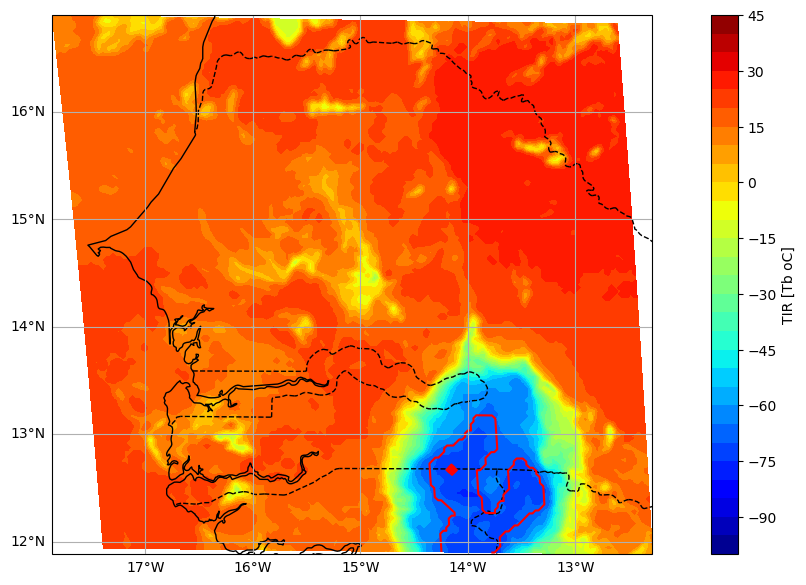

In [9]:
day = 24*19
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, tir[day,:,:], lon, lat, levels=np.arange(-100,50,5), cbar_label='TIR [Tb oC]', cmap='jet')
#ax.contour(lon, lat, cores[day,:,:], levels=[-5,1,50], colors='r')
ax.contour(lon, lat, cores[day,:,:], colors='r')

#

In [10]:
# read in input data- TIR and historical core data at t<to
# read in historical cores

list_of_file_names = []

for i in range(0,len(time_core),1):
    current_file = str(time_core[i])    #+'.nc'
    #print(current_file)
    SY= current_file[0:4]
    MM= current_file[4:6]
    DD= current_file[6:8]
    all_file_names = '/prj/Africa_cloud/hist_nflics_nowcasts/'+SY+'/'+MM+'/'+DD+'/Hist_nowcast_v1_wa_'+current_file[0:-2]+'_flt_ALL.nc' 
    #print(all_file_names)
    if os.path.isfile(all_file_names):      
        list_of_file_names.append(all_file_names) # all days in month
    else:
        list_of_file_names.append('file_not_available') # all days in month
            
                     

In [11]:
dumy_temp = np.zeros((len(lat[:,1]),len(lon[1,:])))
hist_cores = np.zeros((t*24,len(lat[:,1]),len(lon[1,:])),dtype=float) 
# hist_cores_temp= np.zeros((len(reg_lat),len(reg_lon)))*np.nan
num_of_missing_hist_core_files = 0

for l in range(0,len(list_of_file_names),1):   #2, min(t*96,len(list_of_files)), 4):#range(len(list_of_files)): # 96 files per day
    core_filename = list_of_file_names[l]   #'/prj/Africa_cloud/ch9_wavelet/'+str(i)+'/'+month+'/'  list_of_files[l]
    print(core_filename)
    if os.path.isfile(core_filename):      
        ds = xr.open_dataset(core_filename).squeeze() # pick any convective core file from ch9_wavelet. 
        print(l)
        hist_cores_temp = ds['freq'][1,0,:,:].values
        hist_cores[l,:,:] = hist_cores_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
        #hist_cores[l,:,:] = ds['freq'][1,:,:].values
        #time_core[l] = str(core_filename[-15:-3])
        
    else:
        num_of_missing_hist_core_files = num_of_missing_hist_core_files +1
        cores[l,:,:] = dumy_temp
        #tir[l,:,:] = hist_cores_temp 
        #time_core[l] = np.nan#str(core_filename[-15:-3])
        
        

/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010000_flt_ALL.nc
0
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010100_flt_ALL.nc
1
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010200_flt_ALL.nc
2
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010300_flt_ALL.nc
3
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010400_flt_ALL.nc
4
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010500_flt_ALL.nc
5
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010600_flt_ALL.nc
6
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010700_flt_ALL.nc
7
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010800_flt_ALL.nc
8
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010900_flt_ALL.nc
9
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/

85
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006041400_flt_ALL.nc
86
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006041500_flt_ALL.nc
87
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006041600_flt_ALL.nc
88
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006041700_flt_ALL.nc
89
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006041800_flt_ALL.nc
90
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006041900_flt_ALL.nc
91
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006042000_flt_ALL.nc
92
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006042100_flt_ALL.nc
93
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006042200_flt_ALL.nc
94
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006042300_flt_ALL.nc
95
/prj/Africa_cloud/hist_nflics_nowcast

/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006080300_flt_ALL.nc
171
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006080400_flt_ALL.nc
172
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006080500_flt_ALL.nc
173
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006080600_flt_ALL.nc
174
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006080700_flt_ALL.nc
175
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006080800_flt_ALL.nc
176
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006080900_flt_ALL.nc
177
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006081000_flt_ALL.nc
178
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006081100_flt_ALL.nc
179
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006081200_flt_ALL.nc
180
/prj/Africa_cloud/hist_nflics_

257
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/11/Hist_nowcast_v1_wa_201006111800_flt_ALL.nc
258
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/11/Hist_nowcast_v1_wa_201006111900_flt_ALL.nc
259
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/11/Hist_nowcast_v1_wa_201006112000_flt_ALL.nc
260
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/11/Hist_nowcast_v1_wa_201006112100_flt_ALL.nc
261
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/11/Hist_nowcast_v1_wa_201006112200_flt_ALL.nc
262
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/11/Hist_nowcast_v1_wa_201006112300_flt_ALL.nc
263
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/12/Hist_nowcast_v1_wa_201006120000_flt_ALL.nc
264
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/12/Hist_nowcast_v1_wa_201006120100_flt_ALL.nc
265
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/12/Hist_nowcast_v1_wa_201006120200_flt_ALL.nc
266
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/12/Hist_nowcast_v1_wa_201006120300_flt_ALL.nc
267
/prj/Africa_cloud/hist_nfl

347
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006151200_flt_ALL.nc
348
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006151300_flt_ALL.nc
349
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006151400_flt_ALL.nc
350
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006151500_flt_ALL.nc
351
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006151600_flt_ALL.nc
352
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006151700_flt_ALL.nc
353
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006151800_flt_ALL.nc
354
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006151900_flt_ALL.nc
355
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006152000_flt_ALL.nc
356
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006152100_flt_ALL.nc
357
/prj/Africa_cloud/hist_nfl

432
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/19/Hist_nowcast_v1_wa_201006190100_flt_ALL.nc
433
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/19/Hist_nowcast_v1_wa_201006190200_flt_ALL.nc
434
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/19/Hist_nowcast_v1_wa_201006190300_flt_ALL.nc
435
file_not_available
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/19/Hist_nowcast_v1_wa_201006190500_flt_ALL.nc
437
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/19/Hist_nowcast_v1_wa_201006190600_flt_ALL.nc
438
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/19/Hist_nowcast_v1_wa_201006190700_flt_ALL.nc
439
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/19/Hist_nowcast_v1_wa_201006190800_flt_ALL.nc
440
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/19/Hist_nowcast_v1_wa_201006190900_flt_ALL.nc
441
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/19/Hist_nowcast_v1_wa_201006191000_flt_ALL.nc
442
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/19/Hist_nowcast_v1_wa_201006191100_flt_ALL.nc
443
file_no

/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006221600_flt_ALL.nc
520
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006221700_flt_ALL.nc
521
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006221800_flt_ALL.nc
522
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006221900_flt_ALL.nc
523
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006222000_flt_ALL.nc
524
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006222100_flt_ALL.nc
525
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006222200_flt_ALL.nc
526
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006222300_flt_ALL.nc
527
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/23/Hist_nowcast_v1_wa_201006230000_flt_ALL.nc
528
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/23/Hist_nowcast_v1_wa_201006230100_flt_ALL.nc
529
/prj/Africa_cloud/hist_nflics_

604
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006260500_flt_ALL.nc
605
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006260600_flt_ALL.nc
606
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006260700_flt_ALL.nc
607
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006260800_flt_ALL.nc
608
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006260900_flt_ALL.nc
609
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006261000_flt_ALL.nc
610
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006261100_flt_ALL.nc
611
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006261200_flt_ALL.nc
612
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006261300_flt_ALL.nc
613
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006261400_flt_ALL.nc
614
/prj/Africa_cloud/hist_nfl

689
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006291800_flt_ALL.nc
690
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006291900_flt_ALL.nc
691
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006292000_flt_ALL.nc
692
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006292100_flt_ALL.nc
693
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006292200_flt_ALL.nc
694
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006292300_flt_ALL.nc
695
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/30/Hist_nowcast_v1_wa_201006300000_flt_ALL.nc
696
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/30/Hist_nowcast_v1_wa_201006300100_flt_ALL.nc
697
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/30/Hist_nowcast_v1_wa_201006300200_flt_ALL.nc
698
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/30/Hist_nowcast_v1_wa_201006300300_flt_ALL.nc
699
/prj/Africa_cloud/hist_nfl

774
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007030700_flt_ALL.nc
775
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007030800_flt_ALL.nc
776
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007030900_flt_ALL.nc
777
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007031000_flt_ALL.nc
778
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007031100_flt_ALL.nc
779
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007031200_flt_ALL.nc
780
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007031300_flt_ALL.nc
781
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007031400_flt_ALL.nc
782
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007031500_flt_ALL.nc
783
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007031600_flt_ALL.nc
784
/prj/Africa_cloud/hist_nfl

859
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/06/Hist_nowcast_v1_wa_201007062000_flt_ALL.nc
860
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/06/Hist_nowcast_v1_wa_201007062100_flt_ALL.nc
861
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/06/Hist_nowcast_v1_wa_201007062200_flt_ALL.nc
862
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/06/Hist_nowcast_v1_wa_201007062300_flt_ALL.nc
863
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/07/Hist_nowcast_v1_wa_201007070000_flt_ALL.nc
864
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/07/Hist_nowcast_v1_wa_201007070100_flt_ALL.nc
865
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/07/Hist_nowcast_v1_wa_201007070200_flt_ALL.nc
866
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/07/Hist_nowcast_v1_wa_201007070300_flt_ALL.nc
867
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/07/Hist_nowcast_v1_wa_201007070400_flt_ALL.nc
868
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/07/Hist_nowcast_v1_wa_201007070500_flt_ALL.nc
869
/prj/Africa_cloud/hist_nfl

944
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007100900_flt_ALL.nc
945
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007101000_flt_ALL.nc
946
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007101100_flt_ALL.nc
947
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007101200_flt_ALL.nc
948
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007101300_flt_ALL.nc
949
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007101400_flt_ALL.nc
950
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007101500_flt_ALL.nc
951
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007101600_flt_ALL.nc
952
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007101700_flt_ALL.nc
953
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007101800_flt_ALL.nc
954
/prj/Africa_cloud/hist_nfl

1029
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/13/Hist_nowcast_v1_wa_201007132200_flt_ALL.nc
1030
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/13/Hist_nowcast_v1_wa_201007132300_flt_ALL.nc
1031
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/14/Hist_nowcast_v1_wa_201007140000_flt_ALL.nc
1032
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/14/Hist_nowcast_v1_wa_201007140100_flt_ALL.nc
1033
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/14/Hist_nowcast_v1_wa_201007140200_flt_ALL.nc
1034
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/14/Hist_nowcast_v1_wa_201007140300_flt_ALL.nc
1035
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/14/Hist_nowcast_v1_wa_201007140400_flt_ALL.nc
1036
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/14/Hist_nowcast_v1_wa_201007140500_flt_ALL.nc
1037
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/14/Hist_nowcast_v1_wa_201007140600_flt_ALL.nc
1038
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/14/Hist_nowcast_v1_wa_201007140700_flt_ALL.nc
1039
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007171000_flt_ALL.nc
1114
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007171100_flt_ALL.nc
1115
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007171200_flt_ALL.nc
1116
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007171300_flt_ALL.nc
1117
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007171400_flt_ALL.nc
1118
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007171500_flt_ALL.nc
1119
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007171600_flt_ALL.nc
1120
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007171700_flt_ALL.nc
1121
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007171800_flt_ALL.nc
1122
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007171900_flt_ALL.nc
1123
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/20/Hist_nowcast_v1_wa_201007202200_flt_ALL.nc
1198
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/20/Hist_nowcast_v1_wa_201007202300_flt_ALL.nc
1199
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/21/Hist_nowcast_v1_wa_201007210000_flt_ALL.nc
1200
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/21/Hist_nowcast_v1_wa_201007210100_flt_ALL.nc
1201
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/21/Hist_nowcast_v1_wa_201007210200_flt_ALL.nc
1202
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/21/Hist_nowcast_v1_wa_201007210300_flt_ALL.nc
1203
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/21/Hist_nowcast_v1_wa_201007210400_flt_ALL.nc
1204
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/21/Hist_nowcast_v1_wa_201007210500_flt_ALL.nc
1205
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/21/Hist_nowcast_v1_wa_201007210600_flt_ALL.nc
1206
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/21/Hist_nowcast_v1_wa_201007210700_flt_ALL.nc
1207
/prj/Africa_cloud/hi

1282
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007241100_flt_ALL.nc
1283
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007241200_flt_ALL.nc
1284
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007241300_flt_ALL.nc
1285
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007241400_flt_ALL.nc
1286
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007241500_flt_ALL.nc
1287
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007241600_flt_ALL.nc
1288
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007241700_flt_ALL.nc
1289
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007241800_flt_ALL.nc
1290
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007241900_flt_ALL.nc
1291
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007242000_flt_ALL.nc
1292
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007280600_flt_ALL.nc
1374
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007280700_flt_ALL.nc
1375
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007280800_flt_ALL.nc
1376
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007280900_flt_ALL.nc
1377
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007281000_flt_ALL.nc
1378
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007281100_flt_ALL.nc
1379
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007281200_flt_ALL.nc
1380
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007281300_flt_ALL.nc
1381
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007281400_flt_ALL.nc
1382
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007281500_flt_ALL.nc
1383
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007311800_flt_ALL.nc
1458
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007311900_flt_ALL.nc
1459
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007312000_flt_ALL.nc
1460
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007312100_flt_ALL.nc
1461
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007312200_flt_ALL.nc
1462
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007312300_flt_ALL.nc
1463
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/01/Hist_nowcast_v1_wa_201008010000_flt_ALL.nc
1464
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/01/Hist_nowcast_v1_wa_201008010100_flt_ALL.nc
1465
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/01/Hist_nowcast_v1_wa_201008010200_flt_ALL.nc
1466
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/01/Hist_nowcast_v1_wa_201008010300_flt_ALL.nc
1467
/prj/Africa_cloud/hi

1542
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008040700_flt_ALL.nc
1543
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008040800_flt_ALL.nc
1544
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008040900_flt_ALL.nc
1545
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008041000_flt_ALL.nc
1546
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008041100_flt_ALL.nc
1547
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008041200_flt_ALL.nc
1548
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008041300_flt_ALL.nc
1549
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008041400_flt_ALL.nc
1550
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008041500_flt_ALL.nc
1551
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008041600_flt_ALL.nc
1552
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/07/Hist_nowcast_v1_wa_201008071900_flt_ALL.nc
1627
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/07/Hist_nowcast_v1_wa_201008072000_flt_ALL.nc
1628
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/07/Hist_nowcast_v1_wa_201008072100_flt_ALL.nc
1629
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/07/Hist_nowcast_v1_wa_201008072200_flt_ALL.nc
1630
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/07/Hist_nowcast_v1_wa_201008072300_flt_ALL.nc
1631
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/08/Hist_nowcast_v1_wa_201008080000_flt_ALL.nc
1632
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/08/Hist_nowcast_v1_wa_201008080100_flt_ALL.nc
1633
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/08/Hist_nowcast_v1_wa_201008080200_flt_ALL.nc
1634
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/08/Hist_nowcast_v1_wa_201008080300_flt_ALL.nc
1635
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/08/Hist_nowcast_v1_wa_201008080400_flt_ALL.nc
1636
/prj/Africa_cloud/hi

1711
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008110800_flt_ALL.nc
1712
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008110900_flt_ALL.nc
1713
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008111000_flt_ALL.nc
1714
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008111100_flt_ALL.nc
1715
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008111200_flt_ALL.nc
1716
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008111300_flt_ALL.nc
1717
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008111400_flt_ALL.nc
1718
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008111500_flt_ALL.nc
1719
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008111600_flt_ALL.nc
1720
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008111700_flt_ALL.nc
1721
/prj/Africa_clo

1795
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/14/Hist_nowcast_v1_wa_201008142000_flt_ALL.nc
1796
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/14/Hist_nowcast_v1_wa_201008142100_flt_ALL.nc
1797
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/14/Hist_nowcast_v1_wa_201008142200_flt_ALL.nc
1798
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/14/Hist_nowcast_v1_wa_201008142300_flt_ALL.nc
1799
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/15/Hist_nowcast_v1_wa_201008150000_flt_ALL.nc
1800
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/15/Hist_nowcast_v1_wa_201008150100_flt_ALL.nc
1801
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/15/Hist_nowcast_v1_wa_201008150200_flt_ALL.nc
1802
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/15/Hist_nowcast_v1_wa_201008150300_flt_ALL.nc
1803
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/15/Hist_nowcast_v1_wa_201008150400_flt_ALL.nc
1804
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/15/Hist_nowcast_v1_wa_201008150500_flt_ALL.nc
1805
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008180800_flt_ALL.nc
1880
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008180900_flt_ALL.nc
1881
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008181000_flt_ALL.nc
1882
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008181100_flt_ALL.nc
1883
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008181200_flt_ALL.nc
1884
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008181300_flt_ALL.nc
1885
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008181400_flt_ALL.nc
1886
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008181500_flt_ALL.nc
1887
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008181600_flt_ALL.nc
1888
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008181700_flt_ALL.nc
1889
/prj/Africa_cloud/hi

1963
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/21/Hist_nowcast_v1_wa_201008212000_flt_ALL.nc
1964
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/21/Hist_nowcast_v1_wa_201008212100_flt_ALL.nc
1965
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/21/Hist_nowcast_v1_wa_201008212200_flt_ALL.nc
1966
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/21/Hist_nowcast_v1_wa_201008212300_flt_ALL.nc
1967
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/22/Hist_nowcast_v1_wa_201008220000_flt_ALL.nc
1968
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/22/Hist_nowcast_v1_wa_201008220100_flt_ALL.nc
1969
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/22/Hist_nowcast_v1_wa_201008220200_flt_ALL.nc
1970
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/22/Hist_nowcast_v1_wa_201008220300_flt_ALL.nc
1971
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/22/Hist_nowcast_v1_wa_201008220400_flt_ALL.nc
1972
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/22/Hist_nowcast_v1_wa_201008220500_flt_ALL.nc
1973
/prj/Africa_clo

2047
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008250800_flt_ALL.nc
2048
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008250900_flt_ALL.nc
2049
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008251000_flt_ALL.nc
2050
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008251100_flt_ALL.nc
2051
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008251200_flt_ALL.nc
2052
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008251300_flt_ALL.nc
2053
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008251400_flt_ALL.nc
2054
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008251500_flt_ALL.nc
2055
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008251600_flt_ALL.nc
2056
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008251700_flt_ALL.nc
2057
/prj/Africa_clo

2132
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/28/Hist_nowcast_v1_wa_201008282100_flt_ALL.nc
2133
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/28/Hist_nowcast_v1_wa_201008282200_flt_ALL.nc
2134
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/28/Hist_nowcast_v1_wa_201008282300_flt_ALL.nc
2135
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/29/Hist_nowcast_v1_wa_201008290000_flt_ALL.nc
2136
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/29/Hist_nowcast_v1_wa_201008290100_flt_ALL.nc
2137
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/29/Hist_nowcast_v1_wa_201008290200_flt_ALL.nc
2138
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/29/Hist_nowcast_v1_wa_201008290300_flt_ALL.nc
2139
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/29/Hist_nowcast_v1_wa_201008290400_flt_ALL.nc
2140
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/29/Hist_nowcast_v1_wa_201008290500_flt_ALL.nc
2141
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/29/Hist_nowcast_v1_wa_201008290600_flt_ALL.nc
2142
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009010900_flt_ALL.nc
2217
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009011000_flt_ALL.nc
2218
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009011100_flt_ALL.nc
2219
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009011200_flt_ALL.nc
2220
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009011300_flt_ALL.nc
2221
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009011400_flt_ALL.nc
2222
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009011500_flt_ALL.nc
2223
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009011600_flt_ALL.nc
2224
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009011700_flt_ALL.nc
2225
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009011800_flt_ALL.nc
2226
/prj/Africa_cloud/hi

2300
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/04/Hist_nowcast_v1_wa_201009042100_flt_ALL.nc
2301
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/04/Hist_nowcast_v1_wa_201009042200_flt_ALL.nc
2302
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/04/Hist_nowcast_v1_wa_201009042300_flt_ALL.nc
2303
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/05/Hist_nowcast_v1_wa_201009050000_flt_ALL.nc
2304
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/05/Hist_nowcast_v1_wa_201009050100_flt_ALL.nc
2305
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/05/Hist_nowcast_v1_wa_201009050200_flt_ALL.nc
2306
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/05/Hist_nowcast_v1_wa_201009050300_flt_ALL.nc
2307
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/05/Hist_nowcast_v1_wa_201009050400_flt_ALL.nc
2308
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/05/Hist_nowcast_v1_wa_201009050500_flt_ALL.nc
2309
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/05/Hist_nowcast_v1_wa_201009050600_flt_ALL.nc
2310
/prj/Africa_clo

2385
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009081000_flt_ALL.nc
2386
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009081100_flt_ALL.nc
2387
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009081200_flt_ALL.nc
2388
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009081300_flt_ALL.nc
2389
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009081400_flt_ALL.nc
2390
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009081500_flt_ALL.nc
2391
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009081600_flt_ALL.nc
2392
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009081700_flt_ALL.nc
2393
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009081800_flt_ALL.nc
2394
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009081900_flt_ALL.nc
2395
/prj/Africa_clo

2470
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/11/Hist_nowcast_v1_wa_201009112300_flt_ALL.nc
2471
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/12/Hist_nowcast_v1_wa_201009120000_flt_ALL.nc
2472
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/12/Hist_nowcast_v1_wa_201009120100_flt_ALL.nc
2473
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/12/Hist_nowcast_v1_wa_201009120200_flt_ALL.nc
2474
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/12/Hist_nowcast_v1_wa_201009120300_flt_ALL.nc
2475
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/12/Hist_nowcast_v1_wa_201009120400_flt_ALL.nc
2476
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/12/Hist_nowcast_v1_wa_201009120500_flt_ALL.nc
2477
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/12/Hist_nowcast_v1_wa_201009120600_flt_ALL.nc
2478
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/12/Hist_nowcast_v1_wa_201009120700_flt_ALL.nc
2479
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/12/Hist_nowcast_v1_wa_201009120800_flt_ALL.nc
2480
/prj/Africa_clo

2555
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009151200_flt_ALL.nc
2556
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009151300_flt_ALL.nc
2557
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009151400_flt_ALL.nc
2558
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009151500_flt_ALL.nc
2559
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009151600_flt_ALL.nc
2560
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009151700_flt_ALL.nc
2561
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009151800_flt_ALL.nc
2562
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009151900_flt_ALL.nc
2563
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009152000_flt_ALL.nc
2564
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009152100_flt_ALL.nc
2565
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/19/Hist_nowcast_v1_wa_201009190000_flt_ALL.nc
2640
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/19/Hist_nowcast_v1_wa_201009190100_flt_ALL.nc
2641
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/19/Hist_nowcast_v1_wa_201009190200_flt_ALL.nc
2642
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/19/Hist_nowcast_v1_wa_201009190300_flt_ALL.nc
2643
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/19/Hist_nowcast_v1_wa_201009190400_flt_ALL.nc
2644
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/19/Hist_nowcast_v1_wa_201009190500_flt_ALL.nc
2645
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/19/Hist_nowcast_v1_wa_201009190600_flt_ALL.nc
2646
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/19/Hist_nowcast_v1_wa_201009190700_flt_ALL.nc
2647
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/19/Hist_nowcast_v1_wa_201009190800_flt_ALL.nc
2648
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/19/Hist_nowcast_v1_wa_201009190900_flt_ALL.nc
2649
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009221200_flt_ALL.nc
2724
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009221300_flt_ALL.nc
2725
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009221400_flt_ALL.nc
2726
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009221500_flt_ALL.nc
2727
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009221600_flt_ALL.nc
2728
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009221700_flt_ALL.nc
2729
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009221800_flt_ALL.nc
2730
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009221900_flt_ALL.nc
2731
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009222000_flt_ALL.nc
2732
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009222100_flt_ALL.nc
2733
/prj/Africa_cloud/hi

2807
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/26/Hist_nowcast_v1_wa_201009260000_flt_ALL.nc
2808
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/26/Hist_nowcast_v1_wa_201009260100_flt_ALL.nc
2809
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/26/Hist_nowcast_v1_wa_201009260200_flt_ALL.nc
2810
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/26/Hist_nowcast_v1_wa_201009260300_flt_ALL.nc
2811
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/26/Hist_nowcast_v1_wa_201009260400_flt_ALL.nc
2812
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/26/Hist_nowcast_v1_wa_201009260500_flt_ALL.nc
2813
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/26/Hist_nowcast_v1_wa_201009260600_flt_ALL.nc
2814
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/26/Hist_nowcast_v1_wa_201009260700_flt_ALL.nc
2815
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/26/Hist_nowcast_v1_wa_201009260800_flt_ALL.nc
2816
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/26/Hist_nowcast_v1_wa_201009260900_flt_ALL.nc
2817
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009291300_flt_ALL.nc
2893
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009291400_flt_ALL.nc
2894
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009291500_flt_ALL.nc
2895
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009291600_flt_ALL.nc
2896
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009291700_flt_ALL.nc
2897
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009291800_flt_ALL.nc
2898
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009291900_flt_ALL.nc
2899
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009292000_flt_ALL.nc
2900
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009292100_flt_ALL.nc
2901
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009292200_flt_ALL.nc
2902
/prj/Africa_cloud/hi

2977
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/03/Hist_nowcast_v1_wa_201006030200_flt_ALL.nc
2978
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/03/Hist_nowcast_v1_wa_201006030300_flt_ALL.nc
2979
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/03/Hist_nowcast_v1_wa_201006030400_flt_ALL.nc
2980
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/03/Hist_nowcast_v1_wa_201006030500_flt_ALL.nc
2981
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/03/Hist_nowcast_v1_wa_201006030600_flt_ALL.nc
2982
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/03/Hist_nowcast_v1_wa_201006030700_flt_ALL.nc
2983
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/03/Hist_nowcast_v1_wa_201006030800_flt_ALL.nc
2984
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/03/Hist_nowcast_v1_wa_201006030900_flt_ALL.nc
2985
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/03/Hist_nowcast_v1_wa_201006031000_flt_ALL.nc
2986
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/03/Hist_nowcast_v1_wa_201006031100_flt_ALL.nc
2987
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/06/Hist_nowcast_v1_wa_201006061400_flt_ALL.nc
3062
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/06/Hist_nowcast_v1_wa_201006061500_flt_ALL.nc
3063
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/06/Hist_nowcast_v1_wa_201006061600_flt_ALL.nc
3064
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/06/Hist_nowcast_v1_wa_201006061700_flt_ALL.nc
3065
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/06/Hist_nowcast_v1_wa_201006061800_flt_ALL.nc
3066
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/06/Hist_nowcast_v1_wa_201006061900_flt_ALL.nc
3067
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/06/Hist_nowcast_v1_wa_201006062000_flt_ALL.nc
3068
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/06/Hist_nowcast_v1_wa_201006062100_flt_ALL.nc
3069
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/06/Hist_nowcast_v1_wa_201006062200_flt_ALL.nc
3070
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/06/Hist_nowcast_v1_wa_201006062300_flt_ALL.nc
3071
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/10/Hist_nowcast_v1_wa_201006100200_flt_ALL.nc
3146
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/10/Hist_nowcast_v1_wa_201006100300_flt_ALL.nc
3147
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/10/Hist_nowcast_v1_wa_201006100400_flt_ALL.nc
3148
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/10/Hist_nowcast_v1_wa_201006100500_flt_ALL.nc
3149
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/10/Hist_nowcast_v1_wa_201006100600_flt_ALL.nc
3150
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/10/Hist_nowcast_v1_wa_201006100700_flt_ALL.nc
3151
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/10/Hist_nowcast_v1_wa_201006100800_flt_ALL.nc
3152
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/10/Hist_nowcast_v1_wa_201006100900_flt_ALL.nc
3153
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/10/Hist_nowcast_v1_wa_201006101000_flt_ALL.nc
3154
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/10/Hist_nowcast_v1_wa_201006101100_flt_ALL.nc
3155
/prj/Africa_cloud/hi

3234
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/13/Hist_nowcast_v1_wa_201006131900_flt_ALL.nc
3235
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/13/Hist_nowcast_v1_wa_201006132000_flt_ALL.nc
3236
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/13/Hist_nowcast_v1_wa_201006132100_flt_ALL.nc
3237
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/13/Hist_nowcast_v1_wa_201006132200_flt_ALL.nc
3238
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/13/Hist_nowcast_v1_wa_201006132300_flt_ALL.nc
3239
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/14/Hist_nowcast_v1_wa_201006140000_flt_ALL.nc
3240
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/14/Hist_nowcast_v1_wa_201006140100_flt_ALL.nc
3241
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/14/Hist_nowcast_v1_wa_201006140200_flt_ALL.nc
3242
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/14/Hist_nowcast_v1_wa_201006140300_flt_ALL.nc
3243
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/14/Hist_nowcast_v1_wa_201006140400_flt_ALL.nc
3244
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/17/Hist_nowcast_v1_wa_201006170700_flt_ALL.nc
3319
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/17/Hist_nowcast_v1_wa_201006170800_flt_ALL.nc
3320
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/17/Hist_nowcast_v1_wa_201006170900_flt_ALL.nc
3321
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/17/Hist_nowcast_v1_wa_201006171000_flt_ALL.nc
3322
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/17/Hist_nowcast_v1_wa_201006171100_flt_ALL.nc
3323
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/17/Hist_nowcast_v1_wa_201006171200_flt_ALL.nc
3324
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/17/Hist_nowcast_v1_wa_201006171300_flt_ALL.nc
3325
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/17/Hist_nowcast_v1_wa_201006171400_flt_ALL.nc
3326
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/17/Hist_nowcast_v1_wa_201006171500_flt_ALL.nc
3327
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/17/Hist_nowcast_v1_wa_201006171600_flt_ALL.nc
3328
/prj/Africa_cloud/hi

3404
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/20/Hist_nowcast_v1_wa_201006202100_flt_ALL.nc
3405
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/20/Hist_nowcast_v1_wa_201006202200_flt_ALL.nc
3406
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/20/Hist_nowcast_v1_wa_201006202300_flt_ALL.nc
3407
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/21/Hist_nowcast_v1_wa_201006210000_flt_ALL.nc
3408
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/21/Hist_nowcast_v1_wa_201006210100_flt_ALL.nc
3409
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/21/Hist_nowcast_v1_wa_201006210200_flt_ALL.nc
3410
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/21/Hist_nowcast_v1_wa_201006210300_flt_ALL.nc
3411
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/21/Hist_nowcast_v1_wa_201006210400_flt_ALL.nc
3412
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/21/Hist_nowcast_v1_wa_201006210500_flt_ALL.nc
3413
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/21/Hist_nowcast_v1_wa_201006210600_flt_ALL.nc
3414
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/24/Hist_nowcast_v1_wa_201006240900_flt_ALL.nc
3489
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/24/Hist_nowcast_v1_wa_201006241000_flt_ALL.nc
3490
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/24/Hist_nowcast_v1_wa_201006241100_flt_ALL.nc
3491
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/24/Hist_nowcast_v1_wa_201006241200_flt_ALL.nc
3492
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/24/Hist_nowcast_v1_wa_201006241300_flt_ALL.nc
3493
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/24/Hist_nowcast_v1_wa_201006241400_flt_ALL.nc
3494
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/24/Hist_nowcast_v1_wa_201006241500_flt_ALL.nc
3495
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/24/Hist_nowcast_v1_wa_201006241600_flt_ALL.nc
3496
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/24/Hist_nowcast_v1_wa_201006241700_flt_ALL.nc
3497
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/24/Hist_nowcast_v1_wa_201006241800_flt_ALL.nc
3498
/prj/Africa_cloud/hi

3572
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/27/Hist_nowcast_v1_wa_201006272100_flt_ALL.nc
3573
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/27/Hist_nowcast_v1_wa_201006272200_flt_ALL.nc
3574
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/27/Hist_nowcast_v1_wa_201006272300_flt_ALL.nc
3575
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/28/Hist_nowcast_v1_wa_201006280000_flt_ALL.nc
3576
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/28/Hist_nowcast_v1_wa_201006280100_flt_ALL.nc
3577
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/28/Hist_nowcast_v1_wa_201006280200_flt_ALL.nc
3578
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/28/Hist_nowcast_v1_wa_201006280300_flt_ALL.nc
3579
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/28/Hist_nowcast_v1_wa_201006280400_flt_ALL.nc
3580
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/28/Hist_nowcast_v1_wa_201006280500_flt_ALL.nc
3581
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/28/Hist_nowcast_v1_wa_201006280600_flt_ALL.nc
3582
/prj/Africa_clo

3656
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/01/Hist_nowcast_v1_wa_201007010900_flt_ALL.nc
3657
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/01/Hist_nowcast_v1_wa_201007011000_flt_ALL.nc
3658
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/01/Hist_nowcast_v1_wa_201007011100_flt_ALL.nc
3659
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/01/Hist_nowcast_v1_wa_201007011200_flt_ALL.nc
3660
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/01/Hist_nowcast_v1_wa_201007011300_flt_ALL.nc
3661
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/01/Hist_nowcast_v1_wa_201007011400_flt_ALL.nc
3662
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/01/Hist_nowcast_v1_wa_201007011500_flt_ALL.nc
3663
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/01/Hist_nowcast_v1_wa_201007011600_flt_ALL.nc
3664
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/01/Hist_nowcast_v1_wa_201007011700_flt_ALL.nc
3665
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/01/Hist_nowcast_v1_wa_201007011800_flt_ALL.nc
3666
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/04/Hist_nowcast_v1_wa_201007042100_flt_ALL.nc
3741
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/04/Hist_nowcast_v1_wa_201007042200_flt_ALL.nc
3742
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/04/Hist_nowcast_v1_wa_201007042300_flt_ALL.nc
3743
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/05/Hist_nowcast_v1_wa_201007050000_flt_ALL.nc
3744
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/05/Hist_nowcast_v1_wa_201007050100_flt_ALL.nc
3745
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/05/Hist_nowcast_v1_wa_201007050200_flt_ALL.nc
3746
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/05/Hist_nowcast_v1_wa_201007050300_flt_ALL.nc
3747
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/05/Hist_nowcast_v1_wa_201007050400_flt_ALL.nc
3748
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/05/Hist_nowcast_v1_wa_201007050500_flt_ALL.nc
3749
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/05/Hist_nowcast_v1_wa_201007050600_flt_ALL.nc
3750
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/08/Hist_nowcast_v1_wa_201007080900_flt_ALL.nc
3825
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/08/Hist_nowcast_v1_wa_201007081000_flt_ALL.nc
3826
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/08/Hist_nowcast_v1_wa_201007081100_flt_ALL.nc
3827
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/08/Hist_nowcast_v1_wa_201007081200_flt_ALL.nc
3828
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/08/Hist_nowcast_v1_wa_201007081300_flt_ALL.nc
3829
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/08/Hist_nowcast_v1_wa_201007081400_flt_ALL.nc
3830
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/08/Hist_nowcast_v1_wa_201007081500_flt_ALL.nc
3831
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/08/Hist_nowcast_v1_wa_201007081600_flt_ALL.nc
3832
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/08/Hist_nowcast_v1_wa_201007081700_flt_ALL.nc
3833
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/08/Hist_nowcast_v1_wa_201007081800_flt_ALL.nc
3834
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/11/Hist_nowcast_v1_wa_201007112100_flt_ALL.nc
3909
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/11/Hist_nowcast_v1_wa_201007112200_flt_ALL.nc
3910
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/11/Hist_nowcast_v1_wa_201007112300_flt_ALL.nc
3911
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/12/Hist_nowcast_v1_wa_201007120000_flt_ALL.nc
3912
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/12/Hist_nowcast_v1_wa_201007120100_flt_ALL.nc
3913
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/12/Hist_nowcast_v1_wa_201007120200_flt_ALL.nc
3914
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/12/Hist_nowcast_v1_wa_201007120300_flt_ALL.nc
3915
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/12/Hist_nowcast_v1_wa_201007120400_flt_ALL.nc
3916
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/12/Hist_nowcast_v1_wa_201007120500_flt_ALL.nc
3917
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/12/Hist_nowcast_v1_wa_201007120600_flt_ALL.nc
3918
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/15/Hist_nowcast_v1_wa_201007150900_flt_ALL.nc
3993
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/15/Hist_nowcast_v1_wa_201007151000_flt_ALL.nc
3994
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/15/Hist_nowcast_v1_wa_201007151100_flt_ALL.nc
3995
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/15/Hist_nowcast_v1_wa_201007151200_flt_ALL.nc
3996
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/15/Hist_nowcast_v1_wa_201007151300_flt_ALL.nc
3997
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/15/Hist_nowcast_v1_wa_201007151400_flt_ALL.nc
3998
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/15/Hist_nowcast_v1_wa_201007151500_flt_ALL.nc
3999
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/15/Hist_nowcast_v1_wa_201007151600_flt_ALL.nc
4000
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/15/Hist_nowcast_v1_wa_201007151700_flt_ALL.nc
4001
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/15/Hist_nowcast_v1_wa_201007151800_flt_ALL.nc
4002
/prj/Africa_cloud/hi

4076
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/18/Hist_nowcast_v1_wa_201007182100_flt_ALL.nc
4077
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/18/Hist_nowcast_v1_wa_201007182200_flt_ALL.nc
4078
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/18/Hist_nowcast_v1_wa_201007182300_flt_ALL.nc
4079
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/19/Hist_nowcast_v1_wa_201007190000_flt_ALL.nc
4080
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/19/Hist_nowcast_v1_wa_201007190100_flt_ALL.nc
4081
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/19/Hist_nowcast_v1_wa_201007190200_flt_ALL.nc
4082
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/19/Hist_nowcast_v1_wa_201007190300_flt_ALL.nc
4083
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/19/Hist_nowcast_v1_wa_201007190400_flt_ALL.nc
4084
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/19/Hist_nowcast_v1_wa_201007190500_flt_ALL.nc
4085
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/19/Hist_nowcast_v1_wa_201007190600_flt_ALL.nc
4086
/prj/Africa_clo

4160
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/22/Hist_nowcast_v1_wa_201007220900_flt_ALL.nc
4161
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/22/Hist_nowcast_v1_wa_201007221000_flt_ALL.nc
4162
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/22/Hist_nowcast_v1_wa_201007221100_flt_ALL.nc
4163
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/22/Hist_nowcast_v1_wa_201007221200_flt_ALL.nc
4164
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/22/Hist_nowcast_v1_wa_201007221300_flt_ALL.nc
4165
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/22/Hist_nowcast_v1_wa_201007221400_flt_ALL.nc
4166
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/22/Hist_nowcast_v1_wa_201007221500_flt_ALL.nc
4167
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/22/Hist_nowcast_v1_wa_201007221600_flt_ALL.nc
4168
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/22/Hist_nowcast_v1_wa_201007221700_flt_ALL.nc
4169
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/22/Hist_nowcast_v1_wa_201007221800_flt_ALL.nc
4170
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/26/Hist_nowcast_v1_wa_201007260400_flt_ALL.nc
4252
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/26/Hist_nowcast_v1_wa_201007260500_flt_ALL.nc
4253
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/26/Hist_nowcast_v1_wa_201007260600_flt_ALL.nc
4254
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/26/Hist_nowcast_v1_wa_201007260700_flt_ALL.nc
4255
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/26/Hist_nowcast_v1_wa_201007260800_flt_ALL.nc
4256
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/26/Hist_nowcast_v1_wa_201007260900_flt_ALL.nc
4257
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/26/Hist_nowcast_v1_wa_201007261000_flt_ALL.nc
4258
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/26/Hist_nowcast_v1_wa_201007261100_flt_ALL.nc
4259
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/26/Hist_nowcast_v1_wa_201007261200_flt_ALL.nc
4260
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/26/Hist_nowcast_v1_wa_201007261300_flt_ALL.nc
4261
/prj/Africa_cloud/hi

4335
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/29/Hist_nowcast_v1_wa_201007291600_flt_ALL.nc
4336
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/29/Hist_nowcast_v1_wa_201007291700_flt_ALL.nc
4337
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/29/Hist_nowcast_v1_wa_201007291800_flt_ALL.nc
4338
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/29/Hist_nowcast_v1_wa_201007291900_flt_ALL.nc
4339
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/29/Hist_nowcast_v1_wa_201007292000_flt_ALL.nc
4340
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/29/Hist_nowcast_v1_wa_201007292100_flt_ALL.nc
4341
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/29/Hist_nowcast_v1_wa_201007292200_flt_ALL.nc
4342
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/29/Hist_nowcast_v1_wa_201007292300_flt_ALL.nc
4343
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/30/Hist_nowcast_v1_wa_201007300000_flt_ALL.nc
4344
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/30/Hist_nowcast_v1_wa_201007300100_flt_ALL.nc
4345
/prj/Africa_clo

4419
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/02/Hist_nowcast_v1_wa_201008020400_flt_ALL.nc
4420
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/02/Hist_nowcast_v1_wa_201008020500_flt_ALL.nc
4421
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/02/Hist_nowcast_v1_wa_201008020600_flt_ALL.nc
4422
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/02/Hist_nowcast_v1_wa_201008020700_flt_ALL.nc
4423
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/02/Hist_nowcast_v1_wa_201008020800_flt_ALL.nc
4424
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/02/Hist_nowcast_v1_wa_201008020900_flt_ALL.nc
4425
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/02/Hist_nowcast_v1_wa_201008021000_flt_ALL.nc
4426
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/02/Hist_nowcast_v1_wa_201008021100_flt_ALL.nc
4427
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/02/Hist_nowcast_v1_wa_201008021200_flt_ALL.nc
4428
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/02/Hist_nowcast_v1_wa_201008021300_flt_ALL.nc
4429
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/05/Hist_nowcast_v1_wa_201008051600_flt_ALL.nc
4504
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/05/Hist_nowcast_v1_wa_201008051700_flt_ALL.nc
4505
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/05/Hist_nowcast_v1_wa_201008051800_flt_ALL.nc
4506
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/05/Hist_nowcast_v1_wa_201008051900_flt_ALL.nc
4507
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/05/Hist_nowcast_v1_wa_201008052000_flt_ALL.nc
4508
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/05/Hist_nowcast_v1_wa_201008052100_flt_ALL.nc
4509
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/05/Hist_nowcast_v1_wa_201008052200_flt_ALL.nc
4510
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/05/Hist_nowcast_v1_wa_201008052300_flt_ALL.nc
4511
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/06/Hist_nowcast_v1_wa_201008060000_flt_ALL.nc
4512
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/06/Hist_nowcast_v1_wa_201008060100_flt_ALL.nc
4513
/prj/Africa_cloud/hi

4587
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/09/Hist_nowcast_v1_wa_201008090400_flt_ALL.nc
4588
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/09/Hist_nowcast_v1_wa_201008090500_flt_ALL.nc
4589
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/09/Hist_nowcast_v1_wa_201008090600_flt_ALL.nc
4590
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/09/Hist_nowcast_v1_wa_201008090700_flt_ALL.nc
4591
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/09/Hist_nowcast_v1_wa_201008090800_flt_ALL.nc
4592
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/09/Hist_nowcast_v1_wa_201008090900_flt_ALL.nc
4593
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/09/Hist_nowcast_v1_wa_201008091000_flt_ALL.nc
4594
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/09/Hist_nowcast_v1_wa_201008091100_flt_ALL.nc
4595
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/09/Hist_nowcast_v1_wa_201008091200_flt_ALL.nc
4596
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/09/Hist_nowcast_v1_wa_201008091300_flt_ALL.nc
4597
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/12/Hist_nowcast_v1_wa_201008121600_flt_ALL.nc
4672
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/12/Hist_nowcast_v1_wa_201008121700_flt_ALL.nc
4673
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/12/Hist_nowcast_v1_wa_201008121800_flt_ALL.nc
4674
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/12/Hist_nowcast_v1_wa_201008121900_flt_ALL.nc
4675
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/12/Hist_nowcast_v1_wa_201008122000_flt_ALL.nc
4676
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/12/Hist_nowcast_v1_wa_201008122100_flt_ALL.nc
4677
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/12/Hist_nowcast_v1_wa_201008122200_flt_ALL.nc
4678
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/12/Hist_nowcast_v1_wa_201008122300_flt_ALL.nc
4679
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/13/Hist_nowcast_v1_wa_201008130000_flt_ALL.nc
4680
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/13/Hist_nowcast_v1_wa_201008130100_flt_ALL.nc
4681
/prj/Africa_cloud/hi

4755
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/16/Hist_nowcast_v1_wa_201008160400_flt_ALL.nc
4756
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/16/Hist_nowcast_v1_wa_201008160500_flt_ALL.nc
4757
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/16/Hist_nowcast_v1_wa_201008160600_flt_ALL.nc
4758
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/16/Hist_nowcast_v1_wa_201008160700_flt_ALL.nc
4759
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/16/Hist_nowcast_v1_wa_201008160800_flt_ALL.nc
4760
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/16/Hist_nowcast_v1_wa_201008160900_flt_ALL.nc
4761
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/16/Hist_nowcast_v1_wa_201008161000_flt_ALL.nc
4762
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/16/Hist_nowcast_v1_wa_201008161100_flt_ALL.nc
4763
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/16/Hist_nowcast_v1_wa_201008161200_flt_ALL.nc
4764
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/16/Hist_nowcast_v1_wa_201008161300_flt_ALL.nc
4765
/prj/Africa_clo

4840
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/19/Hist_nowcast_v1_wa_201008191700_flt_ALL.nc
4841
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/19/Hist_nowcast_v1_wa_201008191800_flt_ALL.nc
4842
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/19/Hist_nowcast_v1_wa_201008191900_flt_ALL.nc
4843
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/19/Hist_nowcast_v1_wa_201008192000_flt_ALL.nc
4844
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/19/Hist_nowcast_v1_wa_201008192100_flt_ALL.nc
4845
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/19/Hist_nowcast_v1_wa_201008192200_flt_ALL.nc
4846
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/19/Hist_nowcast_v1_wa_201008192300_flt_ALL.nc
4847
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/20/Hist_nowcast_v1_wa_201008200000_flt_ALL.nc
4848
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/20/Hist_nowcast_v1_wa_201008200100_flt_ALL.nc
4849
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/20/Hist_nowcast_v1_wa_201008200200_flt_ALL.nc
4850
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/23/Hist_nowcast_v1_wa_201008230500_flt_ALL.nc
4925
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/23/Hist_nowcast_v1_wa_201008230600_flt_ALL.nc
4926
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/23/Hist_nowcast_v1_wa_201008230700_flt_ALL.nc
4927
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/23/Hist_nowcast_v1_wa_201008230800_flt_ALL.nc
4928
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/23/Hist_nowcast_v1_wa_201008230900_flt_ALL.nc
4929
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/23/Hist_nowcast_v1_wa_201008231000_flt_ALL.nc
4930
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/23/Hist_nowcast_v1_wa_201008231100_flt_ALL.nc
4931
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/23/Hist_nowcast_v1_wa_201008231200_flt_ALL.nc
4932
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/23/Hist_nowcast_v1_wa_201008231300_flt_ALL.nc
4933
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/23/Hist_nowcast_v1_wa_201008231400_flt_ALL.nc
4934
/prj/Africa_cloud/hi

5008
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/26/Hist_nowcast_v1_wa_201008261700_flt_ALL.nc
5009
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/26/Hist_nowcast_v1_wa_201008261800_flt_ALL.nc
5010
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/26/Hist_nowcast_v1_wa_201008261900_flt_ALL.nc
5011
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/26/Hist_nowcast_v1_wa_201008262000_flt_ALL.nc
5012
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/26/Hist_nowcast_v1_wa_201008262100_flt_ALL.nc
5013
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/26/Hist_nowcast_v1_wa_201008262200_flt_ALL.nc
5014
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/26/Hist_nowcast_v1_wa_201008262300_flt_ALL.nc
5015
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/27/Hist_nowcast_v1_wa_201008270000_flt_ALL.nc
5016
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/27/Hist_nowcast_v1_wa_201008270100_flt_ALL.nc
5017
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/27/Hist_nowcast_v1_wa_201008270200_flt_ALL.nc
5018
/prj/Africa_clo

5092
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/30/Hist_nowcast_v1_wa_201008300500_flt_ALL.nc
5093
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/30/Hist_nowcast_v1_wa_201008300600_flt_ALL.nc
5094
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/30/Hist_nowcast_v1_wa_201008300700_flt_ALL.nc
5095
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/30/Hist_nowcast_v1_wa_201008300800_flt_ALL.nc
5096
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/30/Hist_nowcast_v1_wa_201008300900_flt_ALL.nc
5097
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/30/Hist_nowcast_v1_wa_201008301000_flt_ALL.nc
5098
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/30/Hist_nowcast_v1_wa_201008301100_flt_ALL.nc
5099
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/30/Hist_nowcast_v1_wa_201008301200_flt_ALL.nc
5100
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/30/Hist_nowcast_v1_wa_201008301300_flt_ALL.nc
5101
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/30/Hist_nowcast_v1_wa_201008301400_flt_ALL.nc
5102
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/02/Hist_nowcast_v1_wa_201009021700_flt_ALL.nc
5177
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/02/Hist_nowcast_v1_wa_201009021800_flt_ALL.nc
5178
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/02/Hist_nowcast_v1_wa_201009021900_flt_ALL.nc
5179
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/02/Hist_nowcast_v1_wa_201009022000_flt_ALL.nc
5180
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/02/Hist_nowcast_v1_wa_201009022100_flt_ALL.nc
5181
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/02/Hist_nowcast_v1_wa_201009022200_flt_ALL.nc
5182
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/02/Hist_nowcast_v1_wa_201009022300_flt_ALL.nc
5183
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/03/Hist_nowcast_v1_wa_201009030000_flt_ALL.nc
5184
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/03/Hist_nowcast_v1_wa_201009030100_flt_ALL.nc
5185
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/03/Hist_nowcast_v1_wa_201009030200_flt_ALL.nc
5186
/prj/Africa_cloud/hi

5260
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/06/Hist_nowcast_v1_wa_201009060500_flt_ALL.nc
5261
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/06/Hist_nowcast_v1_wa_201009060600_flt_ALL.nc
5262
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/06/Hist_nowcast_v1_wa_201009060700_flt_ALL.nc
5263
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/06/Hist_nowcast_v1_wa_201009060800_flt_ALL.nc
5264
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/06/Hist_nowcast_v1_wa_201009060900_flt_ALL.nc
5265
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/06/Hist_nowcast_v1_wa_201009061000_flt_ALL.nc
5266
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/06/Hist_nowcast_v1_wa_201009061100_flt_ALL.nc
5267
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/06/Hist_nowcast_v1_wa_201009061200_flt_ALL.nc
5268
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/06/Hist_nowcast_v1_wa_201009061300_flt_ALL.nc
5269
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/06/Hist_nowcast_v1_wa_201009061400_flt_ALL.nc
5270
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/09/Hist_nowcast_v1_wa_201009091700_flt_ALL.nc
5345
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/09/Hist_nowcast_v1_wa_201009091800_flt_ALL.nc
5346
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/09/Hist_nowcast_v1_wa_201009091900_flt_ALL.nc
5347
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/09/Hist_nowcast_v1_wa_201009092000_flt_ALL.nc
5348
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/09/Hist_nowcast_v1_wa_201009092100_flt_ALL.nc
5349
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/09/Hist_nowcast_v1_wa_201009092200_flt_ALL.nc
5350
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/09/Hist_nowcast_v1_wa_201009092300_flt_ALL.nc
5351
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/10/Hist_nowcast_v1_wa_201009100000_flt_ALL.nc
5352
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/10/Hist_nowcast_v1_wa_201009100100_flt_ALL.nc
5353
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/10/Hist_nowcast_v1_wa_201009100200_flt_ALL.nc
5354
/prj/Africa_cloud/hi

5428
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/13/Hist_nowcast_v1_wa_201009130500_flt_ALL.nc
5429
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/13/Hist_nowcast_v1_wa_201009130600_flt_ALL.nc
5430
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/13/Hist_nowcast_v1_wa_201009130700_flt_ALL.nc
5431
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/13/Hist_nowcast_v1_wa_201009130800_flt_ALL.nc
5432
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/13/Hist_nowcast_v1_wa_201009130900_flt_ALL.nc
5433
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/13/Hist_nowcast_v1_wa_201009131000_flt_ALL.nc
5434
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/13/Hist_nowcast_v1_wa_201009131100_flt_ALL.nc
5435
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/13/Hist_nowcast_v1_wa_201009131200_flt_ALL.nc
5436
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/13/Hist_nowcast_v1_wa_201009131300_flt_ALL.nc
5437
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/13/Hist_nowcast_v1_wa_201009131400_flt_ALL.nc
5438
/prj/Africa_clo

5513
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/16/Hist_nowcast_v1_wa_201009161800_flt_ALL.nc
5514
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/16/Hist_nowcast_v1_wa_201009161900_flt_ALL.nc
5515
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/16/Hist_nowcast_v1_wa_201009162000_flt_ALL.nc
5516
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/16/Hist_nowcast_v1_wa_201009162100_flt_ALL.nc
5517
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/16/Hist_nowcast_v1_wa_201009162200_flt_ALL.nc
5518
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/16/Hist_nowcast_v1_wa_201009162300_flt_ALL.nc
5519
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/17/Hist_nowcast_v1_wa_201009170000_flt_ALL.nc
5520
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/17/Hist_nowcast_v1_wa_201009170100_flt_ALL.nc
5521
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/17/Hist_nowcast_v1_wa_201009170200_flt_ALL.nc
5522
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/17/Hist_nowcast_v1_wa_201009170300_flt_ALL.nc
5523
/prj/Africa_clo

5597
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/20/Hist_nowcast_v1_wa_201009200600_flt_ALL.nc
5598
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/20/Hist_nowcast_v1_wa_201009200700_flt_ALL.nc
5599
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/20/Hist_nowcast_v1_wa_201009200800_flt_ALL.nc
5600
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/20/Hist_nowcast_v1_wa_201009200900_flt_ALL.nc
5601
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/20/Hist_nowcast_v1_wa_201009201000_flt_ALL.nc
5602
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/20/Hist_nowcast_v1_wa_201009201100_flt_ALL.nc
5603
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/20/Hist_nowcast_v1_wa_201009201200_flt_ALL.nc
5604
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/20/Hist_nowcast_v1_wa_201009201300_flt_ALL.nc
5605
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/20/Hist_nowcast_v1_wa_201009201400_flt_ALL.nc
5606
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/20/Hist_nowcast_v1_wa_201009201500_flt_ALL.nc
5607
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/23/Hist_nowcast_v1_wa_201009231800_flt_ALL.nc
5682
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/23/Hist_nowcast_v1_wa_201009231900_flt_ALL.nc
5683
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/23/Hist_nowcast_v1_wa_201009232000_flt_ALL.nc
5684
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/23/Hist_nowcast_v1_wa_201009232100_flt_ALL.nc
5685
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/23/Hist_nowcast_v1_wa_201009232200_flt_ALL.nc
5686
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/23/Hist_nowcast_v1_wa_201009232300_flt_ALL.nc
5687
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/24/Hist_nowcast_v1_wa_201009240000_flt_ALL.nc
5688
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/24/Hist_nowcast_v1_wa_201009240100_flt_ALL.nc
5689
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/24/Hist_nowcast_v1_wa_201009240200_flt_ALL.nc
5690
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/24/Hist_nowcast_v1_wa_201009240300_flt_ALL.nc
5691
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/27/Hist_nowcast_v1_wa_201009270600_flt_ALL.nc
5766
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/27/Hist_nowcast_v1_wa_201009270700_flt_ALL.nc
5767
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/27/Hist_nowcast_v1_wa_201009270800_flt_ALL.nc
5768
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/27/Hist_nowcast_v1_wa_201009270900_flt_ALL.nc
5769
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/27/Hist_nowcast_v1_wa_201009271000_flt_ALL.nc
5770
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/27/Hist_nowcast_v1_wa_201009271100_flt_ALL.nc
5771
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/27/Hist_nowcast_v1_wa_201009271200_flt_ALL.nc
5772
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/27/Hist_nowcast_v1_wa_201009271300_flt_ALL.nc
5773
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/27/Hist_nowcast_v1_wa_201009271400_flt_ALL.nc
5774
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/27/Hist_nowcast_v1_wa_201009271500_flt_ALL.nc
5775
/prj/Africa_cloud/hi

5850
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/30/Hist_nowcast_v1_wa_201009301900_flt_ALL.nc
5851
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/30/Hist_nowcast_v1_wa_201009302000_flt_ALL.nc
5852
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/30/Hist_nowcast_v1_wa_201009302100_flt_ALL.nc
5853
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/30/Hist_nowcast_v1_wa_201009302200_flt_ALL.nc
5854
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/30/Hist_nowcast_v1_wa_201009302300_flt_ALL.nc
5855
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010000_flt_ALL.nc
5856
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010100_flt_ALL.nc
5857
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010200_flt_ALL.nc
5858
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010300_flt_ALL.nc
5859
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010400_flt_ALL.nc
5860
/prj/Africa_clo

5934
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006040700_flt_ALL.nc
5935
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006040800_flt_ALL.nc
5936
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006040900_flt_ALL.nc
5937
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006041000_flt_ALL.nc
5938
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006041100_flt_ALL.nc
5939
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006041200_flt_ALL.nc
5940
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006041300_flt_ALL.nc
5941
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006041400_flt_ALL.nc
5942
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006041500_flt_ALL.nc
5943
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006041600_flt_ALL.nc
5944
/prj/Africa_clo

6018
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/07/Hist_nowcast_v1_wa_201006071900_flt_ALL.nc
6019
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/07/Hist_nowcast_v1_wa_201006072000_flt_ALL.nc
6020
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/07/Hist_nowcast_v1_wa_201006072100_flt_ALL.nc
6021
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/07/Hist_nowcast_v1_wa_201006072200_flt_ALL.nc
6022
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/07/Hist_nowcast_v1_wa_201006072300_flt_ALL.nc
6023
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006080000_flt_ALL.nc
6024
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006080100_flt_ALL.nc
6025
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006080200_flt_ALL.nc
6026
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006080300_flt_ALL.nc
6027
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006080400_flt_ALL.nc
6028
/prj/Africa_clo

6102
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/11/Hist_nowcast_v1_wa_201006110700_flt_ALL.nc
6103
file_not_available
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/11/Hist_nowcast_v1_wa_201006110900_flt_ALL.nc
6105
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/11/Hist_nowcast_v1_wa_201006111000_flt_ALL.nc
6106
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/11/Hist_nowcast_v1_wa_201006111100_flt_ALL.nc
6107
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/11/Hist_nowcast_v1_wa_201006111200_flt_ALL.nc
6108
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/11/Hist_nowcast_v1_wa_201006111300_flt_ALL.nc
6109
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/11/Hist_nowcast_v1_wa_201006111400_flt_ALL.nc
6110
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/11/Hist_nowcast_v1_wa_201006111500_flt_ALL.nc
6111
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/11/Hist_nowcast_v1_wa_201006111600_flt_ALL.nc
6112
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/11/Hist_nowcast_v1_wa_201006111700_flt_ALL.nc
6

6191
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006150000_flt_ALL.nc
6192
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006150100_flt_ALL.nc
6193
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006150200_flt_ALL.nc
6194
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006150300_flt_ALL.nc
6195
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006150400_flt_ALL.nc
6196
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006150500_flt_ALL.nc
6197
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006150600_flt_ALL.nc
6198
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006150700_flt_ALL.nc
6199
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006150800_flt_ALL.nc
6200
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006150900_flt_ALL.nc
6201
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/18/Hist_nowcast_v1_wa_201006181200_flt_ALL.nc
6276
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/18/Hist_nowcast_v1_wa_201006181300_flt_ALL.nc
6277
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/18/Hist_nowcast_v1_wa_201006181400_flt_ALL.nc
6278
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/18/Hist_nowcast_v1_wa_201006181500_flt_ALL.nc
6279
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/18/Hist_nowcast_v1_wa_201006181600_flt_ALL.nc
6280
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/18/Hist_nowcast_v1_wa_201006181700_flt_ALL.nc
6281
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/18/Hist_nowcast_v1_wa_201006181800_flt_ALL.nc
6282
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/18/Hist_nowcast_v1_wa_201006181900_flt_ALL.nc
6283
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/18/Hist_nowcast_v1_wa_201006182000_flt_ALL.nc
6284
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/18/Hist_nowcast_v1_wa_201006182100_flt_ALL.nc
6285
/prj/Africa_cloud/hi

6362
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006220300_flt_ALL.nc
6363
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006220400_flt_ALL.nc
6364
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006220500_flt_ALL.nc
6365
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006220600_flt_ALL.nc
6366
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006220700_flt_ALL.nc
6367
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006220800_flt_ALL.nc
6368
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006220900_flt_ALL.nc
6369
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006221000_flt_ALL.nc
6370
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006221100_flt_ALL.nc
6371
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006221200_flt_ALL.nc
6372
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/25/Hist_nowcast_v1_wa_201006251500_flt_ALL.nc
6447
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/25/Hist_nowcast_v1_wa_201006251600_flt_ALL.nc
6448
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/25/Hist_nowcast_v1_wa_201006251700_flt_ALL.nc
6449
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/25/Hist_nowcast_v1_wa_201006251800_flt_ALL.nc
6450
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/25/Hist_nowcast_v1_wa_201006251900_flt_ALL.nc
6451
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/25/Hist_nowcast_v1_wa_201006252000_flt_ALL.nc
6452
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/25/Hist_nowcast_v1_wa_201006252100_flt_ALL.nc
6453
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/25/Hist_nowcast_v1_wa_201006252200_flt_ALL.nc
6454
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/25/Hist_nowcast_v1_wa_201006252300_flt_ALL.nc
6455
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006260000_flt_ALL.nc
6456
/prj/Africa_cloud/hi

6530
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006290300_flt_ALL.nc
6531
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006290400_flt_ALL.nc
6532
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006290500_flt_ALL.nc
6533
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006290600_flt_ALL.nc
6534
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006290700_flt_ALL.nc
6535
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006290800_flt_ALL.nc
6536
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006290900_flt_ALL.nc
6537
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006291000_flt_ALL.nc
6538
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006291100_flt_ALL.nc
6539
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006291200_flt_ALL.nc
6540
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/02/Hist_nowcast_v1_wa_201007021500_flt_ALL.nc
6615
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/02/Hist_nowcast_v1_wa_201007021600_flt_ALL.nc
6616
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/02/Hist_nowcast_v1_wa_201007021700_flt_ALL.nc
6617
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/02/Hist_nowcast_v1_wa_201007021800_flt_ALL.nc
6618
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/02/Hist_nowcast_v1_wa_201007021900_flt_ALL.nc
6619
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/02/Hist_nowcast_v1_wa_201007022000_flt_ALL.nc
6620
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/02/Hist_nowcast_v1_wa_201007022100_flt_ALL.nc
6621
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/02/Hist_nowcast_v1_wa_201007022200_flt_ALL.nc
6622
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/02/Hist_nowcast_v1_wa_201007022300_flt_ALL.nc
6623
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007030000_flt_ALL.nc
6624
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/06/Hist_nowcast_v1_wa_201007060300_flt_ALL.nc
6699
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/06/Hist_nowcast_v1_wa_201007060400_flt_ALL.nc
6700
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/06/Hist_nowcast_v1_wa_201007060500_flt_ALL.nc
6701
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/06/Hist_nowcast_v1_wa_201007060600_flt_ALL.nc
6702
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/06/Hist_nowcast_v1_wa_201007060700_flt_ALL.nc
6703
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/06/Hist_nowcast_v1_wa_201007060800_flt_ALL.nc
6704
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/06/Hist_nowcast_v1_wa_201007060900_flt_ALL.nc
6705
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/06/Hist_nowcast_v1_wa_201007061000_flt_ALL.nc
6706
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/06/Hist_nowcast_v1_wa_201007061100_flt_ALL.nc
6707
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/06/Hist_nowcast_v1_wa_201007061200_flt_ALL.nc
6708
/prj/Africa_cloud/hi

6782
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/09/Hist_nowcast_v1_wa_201007091500_flt_ALL.nc
6783
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/09/Hist_nowcast_v1_wa_201007091600_flt_ALL.nc
6784
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/09/Hist_nowcast_v1_wa_201007091700_flt_ALL.nc
6785
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/09/Hist_nowcast_v1_wa_201007091800_flt_ALL.nc
6786
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/09/Hist_nowcast_v1_wa_201007091900_flt_ALL.nc
6787
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/09/Hist_nowcast_v1_wa_201007092000_flt_ALL.nc
6788
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/09/Hist_nowcast_v1_wa_201007092100_flt_ALL.nc
6789
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/09/Hist_nowcast_v1_wa_201007092200_flt_ALL.nc
6790
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/09/Hist_nowcast_v1_wa_201007092300_flt_ALL.nc
6791
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007100000_flt_ALL.nc
6792
/prj/Africa_clo

6866
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/13/Hist_nowcast_v1_wa_201007130300_flt_ALL.nc
6867
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/13/Hist_nowcast_v1_wa_201007130400_flt_ALL.nc
6868
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/13/Hist_nowcast_v1_wa_201007130500_flt_ALL.nc
6869
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/13/Hist_nowcast_v1_wa_201007130600_flt_ALL.nc
6870
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/13/Hist_nowcast_v1_wa_201007130700_flt_ALL.nc
6871
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/13/Hist_nowcast_v1_wa_201007130800_flt_ALL.nc
6872
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/13/Hist_nowcast_v1_wa_201007130900_flt_ALL.nc
6873
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/13/Hist_nowcast_v1_wa_201007131000_flt_ALL.nc
6874
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/13/Hist_nowcast_v1_wa_201007131100_flt_ALL.nc
6875
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/13/Hist_nowcast_v1_wa_201007131200_flt_ALL.nc
6876
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/16/Hist_nowcast_v1_wa_201007161500_flt_ALL.nc
6951
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/16/Hist_nowcast_v1_wa_201007161600_flt_ALL.nc
6952
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/16/Hist_nowcast_v1_wa_201007161700_flt_ALL.nc
6953
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/16/Hist_nowcast_v1_wa_201007161800_flt_ALL.nc
6954
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/16/Hist_nowcast_v1_wa_201007161900_flt_ALL.nc
6955
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/16/Hist_nowcast_v1_wa_201007162000_flt_ALL.nc
6956
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/16/Hist_nowcast_v1_wa_201007162100_flt_ALL.nc
6957
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/16/Hist_nowcast_v1_wa_201007162200_flt_ALL.nc
6958
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/16/Hist_nowcast_v1_wa_201007162300_flt_ALL.nc
6959
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007170000_flt_ALL.nc
6960
/prj/Africa_cloud/hi

7034
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/20/Hist_nowcast_v1_wa_201007200300_flt_ALL.nc
7035
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/20/Hist_nowcast_v1_wa_201007200400_flt_ALL.nc
7036
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/20/Hist_nowcast_v1_wa_201007200500_flt_ALL.nc
7037
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/20/Hist_nowcast_v1_wa_201007200600_flt_ALL.nc
7038
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/20/Hist_nowcast_v1_wa_201007200700_flt_ALL.nc
7039
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/20/Hist_nowcast_v1_wa_201007200800_flt_ALL.nc
7040
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/20/Hist_nowcast_v1_wa_201007200900_flt_ALL.nc
7041
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/20/Hist_nowcast_v1_wa_201007201000_flt_ALL.nc
7042
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/20/Hist_nowcast_v1_wa_201007201100_flt_ALL.nc
7043
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/20/Hist_nowcast_v1_wa_201007201200_flt_ALL.nc
7044
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/23/Hist_nowcast_v1_wa_201007231600_flt_ALL.nc
7120
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/23/Hist_nowcast_v1_wa_201007231700_flt_ALL.nc
7121
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/23/Hist_nowcast_v1_wa_201007231800_flt_ALL.nc
7122
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/23/Hist_nowcast_v1_wa_201007231900_flt_ALL.nc
7123
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/23/Hist_nowcast_v1_wa_201007232000_flt_ALL.nc
7124
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/23/Hist_nowcast_v1_wa_201007232100_flt_ALL.nc
7125
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/23/Hist_nowcast_v1_wa_201007232200_flt_ALL.nc
7126
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/23/Hist_nowcast_v1_wa_201007232300_flt_ALL.nc
7127
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007240000_flt_ALL.nc
7128
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007240100_flt_ALL.nc
7129
/prj/Africa_cloud/hi

7211
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/27/Hist_nowcast_v1_wa_201007271200_flt_ALL.nc
7212
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/27/Hist_nowcast_v1_wa_201007271300_flt_ALL.nc
7213
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/27/Hist_nowcast_v1_wa_201007271400_flt_ALL.nc
7214
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/27/Hist_nowcast_v1_wa_201007271500_flt_ALL.nc
7215
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/27/Hist_nowcast_v1_wa_201007271600_flt_ALL.nc
7216
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/27/Hist_nowcast_v1_wa_201007271700_flt_ALL.nc
7217
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/27/Hist_nowcast_v1_wa_201007271800_flt_ALL.nc
7218
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/27/Hist_nowcast_v1_wa_201007271900_flt_ALL.nc
7219
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/27/Hist_nowcast_v1_wa_201007272000_flt_ALL.nc
7220
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/27/Hist_nowcast_v1_wa_201007272100_flt_ALL.nc
7221
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007310000_flt_ALL.nc
7296
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007310100_flt_ALL.nc
7297
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007310200_flt_ALL.nc
7298
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007310300_flt_ALL.nc
7299
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007310400_flt_ALL.nc
7300
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007310500_flt_ALL.nc
7301
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007310600_flt_ALL.nc
7302
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007310700_flt_ALL.nc
7303
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007310800_flt_ALL.nc
7304
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007310900_flt_ALL.nc
7305
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/03/Hist_nowcast_v1_wa_201008031200_flt_ALL.nc
7380
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/03/Hist_nowcast_v1_wa_201008031300_flt_ALL.nc
7381
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/03/Hist_nowcast_v1_wa_201008031400_flt_ALL.nc
7382
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/03/Hist_nowcast_v1_wa_201008031500_flt_ALL.nc
7383
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/03/Hist_nowcast_v1_wa_201008031600_flt_ALL.nc
7384
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/03/Hist_nowcast_v1_wa_201008031700_flt_ALL.nc
7385
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/03/Hist_nowcast_v1_wa_201008031800_flt_ALL.nc
7386
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/03/Hist_nowcast_v1_wa_201008031900_flt_ALL.nc
7387
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/03/Hist_nowcast_v1_wa_201008032000_flt_ALL.nc
7388
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/03/Hist_nowcast_v1_wa_201008032100_flt_ALL.nc
7389
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/07/Hist_nowcast_v1_wa_201008070100_flt_ALL.nc
7465
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/07/Hist_nowcast_v1_wa_201008070200_flt_ALL.nc
7466
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/07/Hist_nowcast_v1_wa_201008070300_flt_ALL.nc
7467
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/07/Hist_nowcast_v1_wa_201008070400_flt_ALL.nc
7468
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/07/Hist_nowcast_v1_wa_201008070500_flt_ALL.nc
7469
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/07/Hist_nowcast_v1_wa_201008070600_flt_ALL.nc
7470
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/07/Hist_nowcast_v1_wa_201008070700_flt_ALL.nc
7471
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/07/Hist_nowcast_v1_wa_201008070800_flt_ALL.nc
7472
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/07/Hist_nowcast_v1_wa_201008070900_flt_ALL.nc
7473
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/07/Hist_nowcast_v1_wa_201008071000_flt_ALL.nc
7474
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/10/Hist_nowcast_v1_wa_201008101300_flt_ALL.nc
7549
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/10/Hist_nowcast_v1_wa_201008101400_flt_ALL.nc
7550
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/10/Hist_nowcast_v1_wa_201008101500_flt_ALL.nc
7551
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/10/Hist_nowcast_v1_wa_201008101600_flt_ALL.nc
7552
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/10/Hist_nowcast_v1_wa_201008101700_flt_ALL.nc
7553
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/10/Hist_nowcast_v1_wa_201008101800_flt_ALL.nc
7554
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/10/Hist_nowcast_v1_wa_201008101900_flt_ALL.nc
7555
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/10/Hist_nowcast_v1_wa_201008102000_flt_ALL.nc
7556
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/10/Hist_nowcast_v1_wa_201008102100_flt_ALL.nc
7557
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/10/Hist_nowcast_v1_wa_201008102200_flt_ALL.nc
7558
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/14/Hist_nowcast_v1_wa_201008140200_flt_ALL.nc
7634
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/14/Hist_nowcast_v1_wa_201008140300_flt_ALL.nc
7635
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/14/Hist_nowcast_v1_wa_201008140400_flt_ALL.nc
7636
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/14/Hist_nowcast_v1_wa_201008140500_flt_ALL.nc
7637
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/14/Hist_nowcast_v1_wa_201008140600_flt_ALL.nc
7638
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/14/Hist_nowcast_v1_wa_201008140700_flt_ALL.nc
7639
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/14/Hist_nowcast_v1_wa_201008140800_flt_ALL.nc
7640
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/14/Hist_nowcast_v1_wa_201008140900_flt_ALL.nc
7641
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/14/Hist_nowcast_v1_wa_201008141000_flt_ALL.nc
7642
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/14/Hist_nowcast_v1_wa_201008141100_flt_ALL.nc
7643
/prj/Africa_cloud/hi

7718
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/17/Hist_nowcast_v1_wa_201008171500_flt_ALL.nc
7719
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/17/Hist_nowcast_v1_wa_201008171600_flt_ALL.nc
7720
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/17/Hist_nowcast_v1_wa_201008171700_flt_ALL.nc
7721
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/17/Hist_nowcast_v1_wa_201008171800_flt_ALL.nc
7722
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/17/Hist_nowcast_v1_wa_201008171900_flt_ALL.nc
7723
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/17/Hist_nowcast_v1_wa_201008172000_flt_ALL.nc
7724
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/17/Hist_nowcast_v1_wa_201008172100_flt_ALL.nc
7725
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/17/Hist_nowcast_v1_wa_201008172200_flt_ALL.nc
7726
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/17/Hist_nowcast_v1_wa_201008172300_flt_ALL.nc
7727
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008180000_flt_ALL.nc
7728
/prj/Africa_clo

7803
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/21/Hist_nowcast_v1_wa_201008210400_flt_ALL.nc
7804
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/21/Hist_nowcast_v1_wa_201008210500_flt_ALL.nc
7805
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/21/Hist_nowcast_v1_wa_201008210600_flt_ALL.nc
7806
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/21/Hist_nowcast_v1_wa_201008210700_flt_ALL.nc
7807
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/21/Hist_nowcast_v1_wa_201008210800_flt_ALL.nc
7808
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/21/Hist_nowcast_v1_wa_201008210900_flt_ALL.nc
7809
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/21/Hist_nowcast_v1_wa_201008211000_flt_ALL.nc
7810
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/21/Hist_nowcast_v1_wa_201008211100_flt_ALL.nc
7811
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/21/Hist_nowcast_v1_wa_201008211200_flt_ALL.nc
7812
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/21/Hist_nowcast_v1_wa_201008211300_flt_ALL.nc
7813
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/24/Hist_nowcast_v1_wa_201008241600_flt_ALL.nc
7888
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/24/Hist_nowcast_v1_wa_201008241700_flt_ALL.nc
7889
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/24/Hist_nowcast_v1_wa_201008241800_flt_ALL.nc
7890
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/24/Hist_nowcast_v1_wa_201008241900_flt_ALL.nc
7891
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/24/Hist_nowcast_v1_wa_201008242000_flt_ALL.nc
7892
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/24/Hist_nowcast_v1_wa_201008242100_flt_ALL.nc
7893
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/24/Hist_nowcast_v1_wa_201008242200_flt_ALL.nc
7894
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/24/Hist_nowcast_v1_wa_201008242300_flt_ALL.nc
7895
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008250000_flt_ALL.nc
7896
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008250100_flt_ALL.nc
7897
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/28/Hist_nowcast_v1_wa_201008280500_flt_ALL.nc
7973
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/28/Hist_nowcast_v1_wa_201008280600_flt_ALL.nc
7974
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/28/Hist_nowcast_v1_wa_201008280700_flt_ALL.nc
7975
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/28/Hist_nowcast_v1_wa_201008280800_flt_ALL.nc
7976
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/28/Hist_nowcast_v1_wa_201008280900_flt_ALL.nc
7977
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/28/Hist_nowcast_v1_wa_201008281000_flt_ALL.nc
7978
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/28/Hist_nowcast_v1_wa_201008281100_flt_ALL.nc
7979
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/28/Hist_nowcast_v1_wa_201008281200_flt_ALL.nc
7980
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/28/Hist_nowcast_v1_wa_201008281300_flt_ALL.nc
7981
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/28/Hist_nowcast_v1_wa_201008281400_flt_ALL.nc
7982
/prj/Africa_cloud/hi

8057
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/31/Hist_nowcast_v1_wa_201008311800_flt_ALL.nc
8058
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/31/Hist_nowcast_v1_wa_201008311900_flt_ALL.nc
8059
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/31/Hist_nowcast_v1_wa_201008312000_flt_ALL.nc
8060
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/31/Hist_nowcast_v1_wa_201008312100_flt_ALL.nc
8061
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/31/Hist_nowcast_v1_wa_201008312200_flt_ALL.nc
8062
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/31/Hist_nowcast_v1_wa_201008312300_flt_ALL.nc
8063
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009010000_flt_ALL.nc
8064
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009010100_flt_ALL.nc
8065
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009010200_flt_ALL.nc
8066
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009010300_flt_ALL.nc
8067
/prj/Africa_clo

8142
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/04/Hist_nowcast_v1_wa_201009040700_flt_ALL.nc
8143
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/04/Hist_nowcast_v1_wa_201009040800_flt_ALL.nc
8144
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/04/Hist_nowcast_v1_wa_201009040900_flt_ALL.nc
8145
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/04/Hist_nowcast_v1_wa_201009041000_flt_ALL.nc
8146
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/04/Hist_nowcast_v1_wa_201009041100_flt_ALL.nc
8147
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/04/Hist_nowcast_v1_wa_201009041200_flt_ALL.nc
8148
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/04/Hist_nowcast_v1_wa_201009041300_flt_ALL.nc
8149
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/04/Hist_nowcast_v1_wa_201009041400_flt_ALL.nc
8150
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/04/Hist_nowcast_v1_wa_201009041500_flt_ALL.nc
8151
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/04/Hist_nowcast_v1_wa_201009041600_flt_ALL.nc
8152
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/07/Hist_nowcast_v1_wa_201009071900_flt_ALL.nc
8227
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/07/Hist_nowcast_v1_wa_201009072000_flt_ALL.nc
8228
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/07/Hist_nowcast_v1_wa_201009072100_flt_ALL.nc
8229
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/07/Hist_nowcast_v1_wa_201009072200_flt_ALL.nc
8230
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/07/Hist_nowcast_v1_wa_201009072300_flt_ALL.nc
8231
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009080000_flt_ALL.nc
8232
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009080100_flt_ALL.nc
8233
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009080200_flt_ALL.nc
8234
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009080300_flt_ALL.nc
8235
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009080400_flt_ALL.nc
8236
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/11/Hist_nowcast_v1_wa_201009110700_flt_ALL.nc
8311
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/11/Hist_nowcast_v1_wa_201009110800_flt_ALL.nc
8312
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/11/Hist_nowcast_v1_wa_201009110900_flt_ALL.nc
8313
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/11/Hist_nowcast_v1_wa_201009111000_flt_ALL.nc
8314
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/11/Hist_nowcast_v1_wa_201009111100_flt_ALL.nc
8315
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/11/Hist_nowcast_v1_wa_201009111200_flt_ALL.nc
8316
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/11/Hist_nowcast_v1_wa_201009111300_flt_ALL.nc
8317
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/11/Hist_nowcast_v1_wa_201009111400_flt_ALL.nc
8318
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/11/Hist_nowcast_v1_wa_201009111500_flt_ALL.nc
8319
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/11/Hist_nowcast_v1_wa_201009111600_flt_ALL.nc
8320
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/14/Hist_nowcast_v1_wa_201009142000_flt_ALL.nc
8396
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/14/Hist_nowcast_v1_wa_201009142100_flt_ALL.nc
8397
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/14/Hist_nowcast_v1_wa_201009142200_flt_ALL.nc
8398
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/14/Hist_nowcast_v1_wa_201009142300_flt_ALL.nc
8399
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009150000_flt_ALL.nc
8400
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009150100_flt_ALL.nc
8401
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009150200_flt_ALL.nc
8402
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009150300_flt_ALL.nc
8403
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009150400_flt_ALL.nc
8404
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009150500_flt_ALL.nc
8405
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/18/Hist_nowcast_v1_wa_201009180800_flt_ALL.nc
8480
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/18/Hist_nowcast_v1_wa_201009180900_flt_ALL.nc
8481
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/18/Hist_nowcast_v1_wa_201009181000_flt_ALL.nc
8482
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/18/Hist_nowcast_v1_wa_201009181100_flt_ALL.nc
8483
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/18/Hist_nowcast_v1_wa_201009181200_flt_ALL.nc
8484
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/18/Hist_nowcast_v1_wa_201009181300_flt_ALL.nc
8485
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/18/Hist_nowcast_v1_wa_201009181400_flt_ALL.nc
8486
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/18/Hist_nowcast_v1_wa_201009181500_flt_ALL.nc
8487
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/18/Hist_nowcast_v1_wa_201009181600_flt_ALL.nc
8488
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/18/Hist_nowcast_v1_wa_201009181700_flt_ALL.nc
8489
/prj/Africa_cloud/hi

8563
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/21/Hist_nowcast_v1_wa_201009212000_flt_ALL.nc
8564
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/21/Hist_nowcast_v1_wa_201009212100_flt_ALL.nc
8565
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/21/Hist_nowcast_v1_wa_201009212200_flt_ALL.nc
8566
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/21/Hist_nowcast_v1_wa_201009212300_flt_ALL.nc
8567
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009220000_flt_ALL.nc
8568
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009220100_flt_ALL.nc
8569
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009220200_flt_ALL.nc
8570
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009220300_flt_ALL.nc
8571
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009220400_flt_ALL.nc
8572
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009220500_flt_ALL.nc
8573
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/25/Hist_nowcast_v1_wa_201009250900_flt_ALL.nc
8649
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/25/Hist_nowcast_v1_wa_201009251000_flt_ALL.nc
8650
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/25/Hist_nowcast_v1_wa_201009251100_flt_ALL.nc
8651
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/25/Hist_nowcast_v1_wa_201009251200_flt_ALL.nc
8652
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/25/Hist_nowcast_v1_wa_201009251300_flt_ALL.nc
8653
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/25/Hist_nowcast_v1_wa_201009251400_flt_ALL.nc
8654
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/25/Hist_nowcast_v1_wa_201009251500_flt_ALL.nc
8655
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/25/Hist_nowcast_v1_wa_201009251600_flt_ALL.nc
8656
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/25/Hist_nowcast_v1_wa_201009251700_flt_ALL.nc
8657
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/25/Hist_nowcast_v1_wa_201009251800_flt_ALL.nc
8658
/prj/Africa_cloud/hi

8732
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/28/Hist_nowcast_v1_wa_201009282100_flt_ALL.nc
8733
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/28/Hist_nowcast_v1_wa_201009282200_flt_ALL.nc
8734
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/28/Hist_nowcast_v1_wa_201009282300_flt_ALL.nc
8735
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009290000_flt_ALL.nc
8736
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009290100_flt_ALL.nc
8737
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009290200_flt_ALL.nc
8738
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009290300_flt_ALL.nc
8739
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009290400_flt_ALL.nc
8740
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009290500_flt_ALL.nc
8741
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009290600_flt_ALL.nc
8742
/prj/Africa_clo

file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_available
file_not_ava

In [252]:
num_of_missing_hist_core_files

11742

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


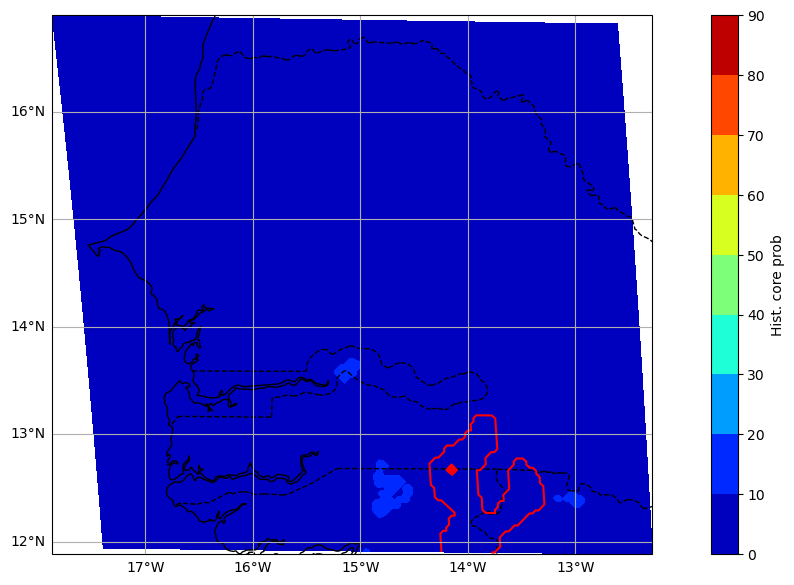

In [12]:
day = 24*19
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, hist_cores[day,:,:], lon, lat, levels=np.arange(0,100,10), cbar_label='Hist. core prob', cmap='jet')
#ax.contour(lon, lat, cores[day,:,:], levels=[-5,1,50], colors='r')
ax.contour(lon, lat, cores[day,:,:], colors='r')

#

In [13]:
# input data- cores_t_0: 
# starting at 
num_frames= 1  #8  # previous 2 hours of images to predict 1 hr later
t0= 0  #1   #*4 # # 15 min  later (4 frames at 15 min)
a= 45
b= 48
#cores_t_minus_xhr = cores[0:-2*t0, a:,b:]
#cores_t_0 = cores[t0:-t0, a:,b:]
#tir_t_minus_xhr = tir[0:-2*t0,a:,b:]
#tir_t_0 = tir[t0:-t0, a:,b:]
cores_t_0 = cores[0:-num_frames-t0, :-a,b:]
tir_t_0 = tir[0:-num_frames-t0, :-a,b:]
hist_cores_t_0 = hist_cores[0:-num_frames-t0, :-a,b:]
# normalize training data 
cores_t_0 = cores_t_0/np.max(cores_t_0)
hist_cores_t_0 = hist_cores_t_0/np.max(hist_cores_t_0)


#target data
cores_t_plus_xhr = cores[t0+num_frames:,:-a,b:]
ind = np.where(cores_t_plus_xhr>0)
cores_t_plus_xhr[ind] = 1
ind_not = np.where(cores_t_plus_xhr<=0)
cores_t_plus_xhr[ind_not] = 0
#print(np.unique(cores_t_plus_xhr))
#print(np.unique(cores_t_0))
#print(np.unique(hist_cores_t_0))


In [14]:
print(np.unique(cores_t_plus_xhr))
print(np.unique(cores_t_0))


[0. 1.]
[0.00000000e+00 3.26360106e-05 6.52720211e-05 ... 9.40765641e-01
 9.59661891e-01 1.00000000e+00]


In [15]:
#cores_t_plus_xhr = cores[t0+num_frames:, a:,b:]
#ind = np.where(cores_t_plus_xhr>0)
#print(np.unique(cores[:t0+num_frames,:-a,b:]))
#print(np.unique(cores[t0+num_frames:,:-a,b:]))
#print(np.unique(cores_t_plus_xhr))
#cores_t_plus_xhr.sum()
#print(cores_t_plus_xhr[ind])
#print(ind)
print(cores_t_0.shape)
print(hist_cores_t_0.shape)
print(cores_t_plus_xhr.shape)
a= 45
b= 48
num_frames= 1  #8  # previous 2 hours of images to predict 1 hr later
t0= 0

(20471, 128, 128)
(20471, 128, 128)
(20471, 128, 128)


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


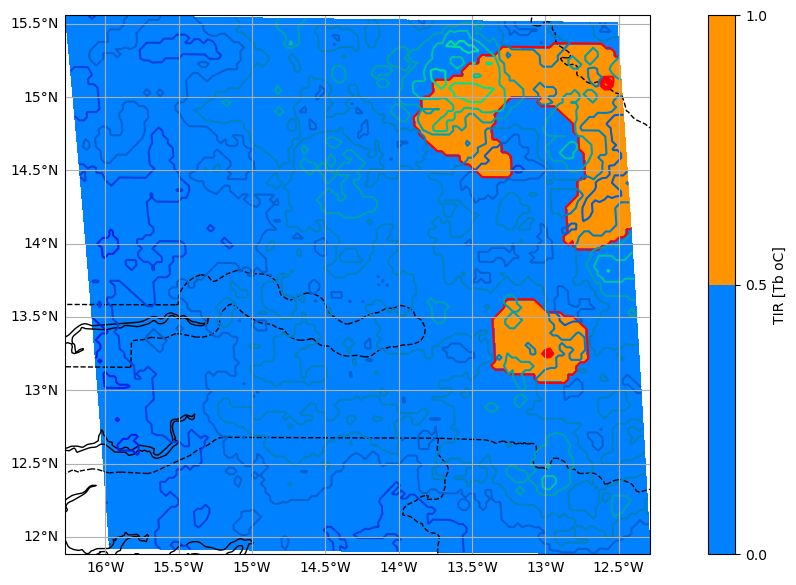

In [16]:
day = 96*19  #t0+num_frames+63  #96*19-36
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, cores_t_plus_xhr[day- (t0+num_frames),:,:], lon[:-a,b:], lat[:-a,b:], levels=[0,0.5,1], cbar_label='TIR [Tb oC]', cmap='jet')
ax.contour(lon[:-a,b:], lat[:-a,b:], cores_t_0[day,:,:], colors='r')
ax.contour(lon[:-a,b:], lat[:-a,b:], hist_cores_t_0[day,:,:], cmap='winter')
#draw_map(ax, cores[day,:-a,b:], lon[:-a,b:], lat[:-a,b:], levels=[0,0.5,1], cbar_label='TIR [Tb oC]', cmap='jet')
#draw_map(ax, cores[day,:-a,b:], lon[:-a,b:], lat[:-a,b:], cbar_label='TIR [Tb oC]', cmap='jet')

#

In [17]:
# save variables 
with open('pkl_files/WA_subdomain_cores_2hr_back_multichannel.pkl', 'wb') as file: 
          pickle.dump([cores_t_0,tir_t_0,hist_cores_t_0,cores_t_plus_xhr], file) 
        

In [18]:
# open a file, where you stored the pickled data
#file = open('pkl_files/WA_subdomain_cores_2hr_back_multichannel.pkl', 'rb')
#data = pickle.load(file)
#cores_t_0= data[0]
#tir_t_0= data[1]
#hist_cores_t_0= data[2]
#cores_t_plus_xhr= data[3]


In [19]:
# Define input shape
#num_frames= 24  # 6 hours
image_height= len(cores_t_plus_xhr[1,:,1]) #lat
image_width= len(cores_t_plus_xhr[1,1,:]) #lon
num_channels= 2 #  core at t0-       tir at t0-x, t0, , cores
#input_shape = (image_height, image_width, num_channels)
#input_shape = (num_frames, image_height, image_width, num_channels)
# Sample data (you should replace this with your own dataset)
#num_samples = len(cores_t_plus_xhr[0,0,:])
#sequence_length = 5



In [20]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, image_height,image_width, num_channels))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=8, #64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=8,#64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=8,#64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=2, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)
#x = layers.Conv3D(
#    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
#)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)


In [21]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 128, 128,   0         
                             2)]                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 128, 128, 8  8032      
                             )                                   
                                                                 
 batch_normalization (BatchN  (None, None, 128, 128, 8  32       
 ormalization)               )                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 128, 128, 8  4640      
                             )                                   
                                                                 
 batch_normalization_1 (Batc  (None, None, 128, 128, 8  32   

In [249]:
num_frames= 4   # 4  hours
batch_size= int(len(cores_t_0[:,0,0])/num_frames)  # days 720 - 96 one day
val_samples= 4000
x_train= np.zeros((batch_size-val_samples,num_frames,image_height,image_width, num_channels))
y_train= np.zeros((batch_size-val_samples,num_frames,image_height,image_width, num_channels))
x_val= np.zeros((val_samples,num_frames,image_height,image_width, num_channels))
y_val= np.zeros((val_samples,num_frames,image_height,image_width, num_channels))
                   
    
for i in range(0,batch_size-val_samples,1):  
    x_train[i,:,:,:,0]= cores_t_0[i*num_frames:(i+1)*num_frames,:,:]
    x_train[i,:,:,:,1]= hist_cores_t_0[i*num_frames:(i+1)*num_frames,:,:]
    y_train[i,:,:,:,0]= cores_t_plus_xhr[i*num_frames:(i+1)*num_frames,:,:]
    
    
val_ind= (i+1)*num_frames
    
for i in range(0,val_samples,1):  
    x_val[i,:,:,:,0]= cores_t_0[i*num_frames+val_ind:(i+1)*num_frames+val_ind,:,:]
    x_val[i,:,:,:,1]= hist_cores_t_0[i*num_frames+val_ind:(i+1)*num_frames+val_ind,:,:]
    y_val[i,:,:,:,0]= cores_t_plus_xhr[i*num_frames+val_ind:(i+1)*num_frames+val_ind,:,:]

           
# normalize input data    - done up already    
#x_train = x_train/np.max(x_train)
#x_val = x_val/np.max(x_train)


In [250]:
print(x_train.shape)
print(x_val.shape)
#batch_size-val_samples
#batch_size

(1117, 4, 128, 128, 2)
(4000, 4, 128, 128, 2)


In [24]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 2 # 20
batch_size = 4 #50# batch_size#24

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/2
1267/1267 [==============================] - 757s 594ms/step - loss: 0.0277 - val_loss: 4.6741e-05 - lr: 0.0010
Epoch 2/2
1267/1267 [==============================] - 753s 594ms/step - loss: 0.0072 - val_loss: 1.3269e-04 - lr: 0.0010


In [25]:
#example = x_val[np.random.choice(range(len(x_val)), size=1)[0]]
#print(example.shape)
#with open('WA_subdomain_trained_model_2hr_back_15min_forward.pkl', 'wb') as file: 
 #   pickle.dump(model, file) 
        

In [26]:
#print(x_val.shape)
#print(predicted_frame.shape)
#print(np.where(all_frames>0.35))

In [231]:
# Select a random example from the validation dataset.
# example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]
# using x_val for now 
#all_frames=np.zeros((50,image_height,image_width, num_channels))

#for b in range(0,51,1):
batch_number = 456 #b #50
frames = x_val[batch_number,0:2,:,:,:] # 
original_frames = x_val[batch_number,2:,:,:,:] # 
#print(frames.shape)
#print(original_frames.shape)
#original_frames = y_val[batch_number,5:,:,:,:] # 
#print(frames.shape)

# Predict a new set of 4 frames.
for _ in range(2):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)
    #all_frames = np.concatenate((all_frames, predicted_frame), axis=0)


1/1 [==============================] - 0s 25ms/step


In [251]:
print(frames.shape)
print(original_frames.shape)
#print(new_prediction.shape)
#print(lon[:-a,b:].shape)
#print(lat[:-a,b:].shape)
#ind = np.where(frames[24:,:,:,0]>0.25)
ind = np.where(x_val[:,:,:,:,0]>0)
print((ind))

(4, 128, 128, 2)
(2, 128, 128, 2)
(array([   0,    0,    0, ..., 1078, 1078, 1078]), array([0, 0, 0, ..., 3, 3, 3]), array([  0,   0,   0, ..., 127, 127, 127]), array([67, 68, 69, ..., 43, 44, 45]))


In [213]:
96*19/4

456.0

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


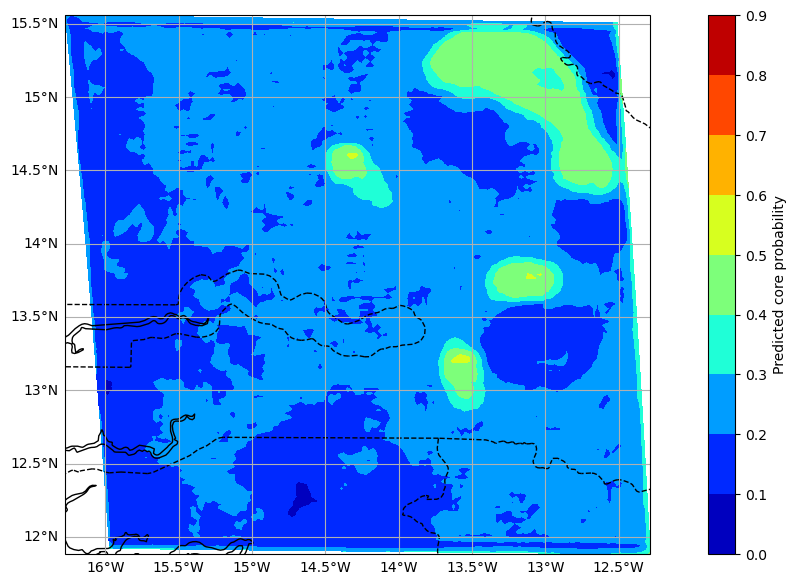

In [232]:
day = 4-2 #96*19-36
f=plt.figure(figsize=(15,7)) 
ax = f.add_subplot(111, projection=ccrs.PlateCarree()) 
draw_map(ax, np.squeeze(frames[day,:,:,0]), lon[:-a,b:], lat[:-a,b:], levels=np.arange(0,1,0.1), cbar_label='Predicted core probability', cmap='jet')

#

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


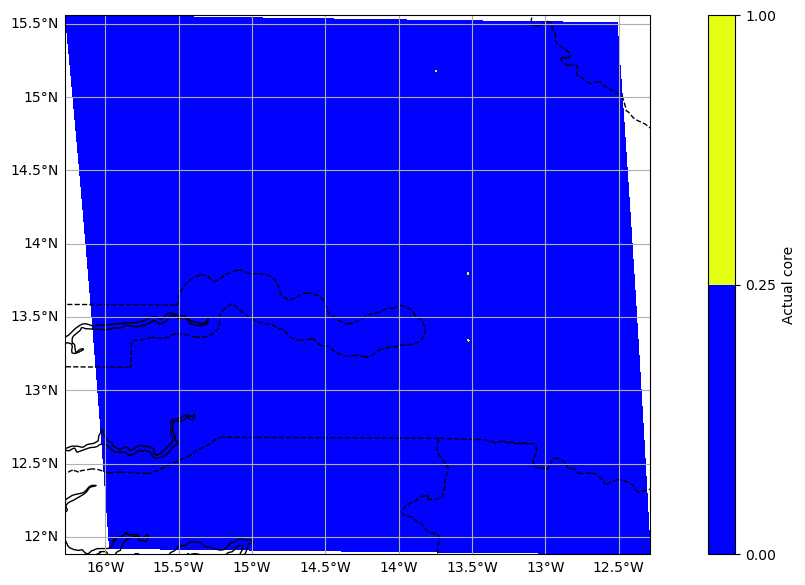

In [234]:
#day = 23 #96*19-36
f=plt.figure(figsize=(15,7)) 
ax = f.add_subplot(111, projection=ccrs.PlateCarree()) 
draw_map(ax, np.squeeze(original_frames[0,:,:,0]), lon[:-a,b:], lat[:-a,b:],levels=[0,.5,1], cbar_label='Actual core', cmap='jet')


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility

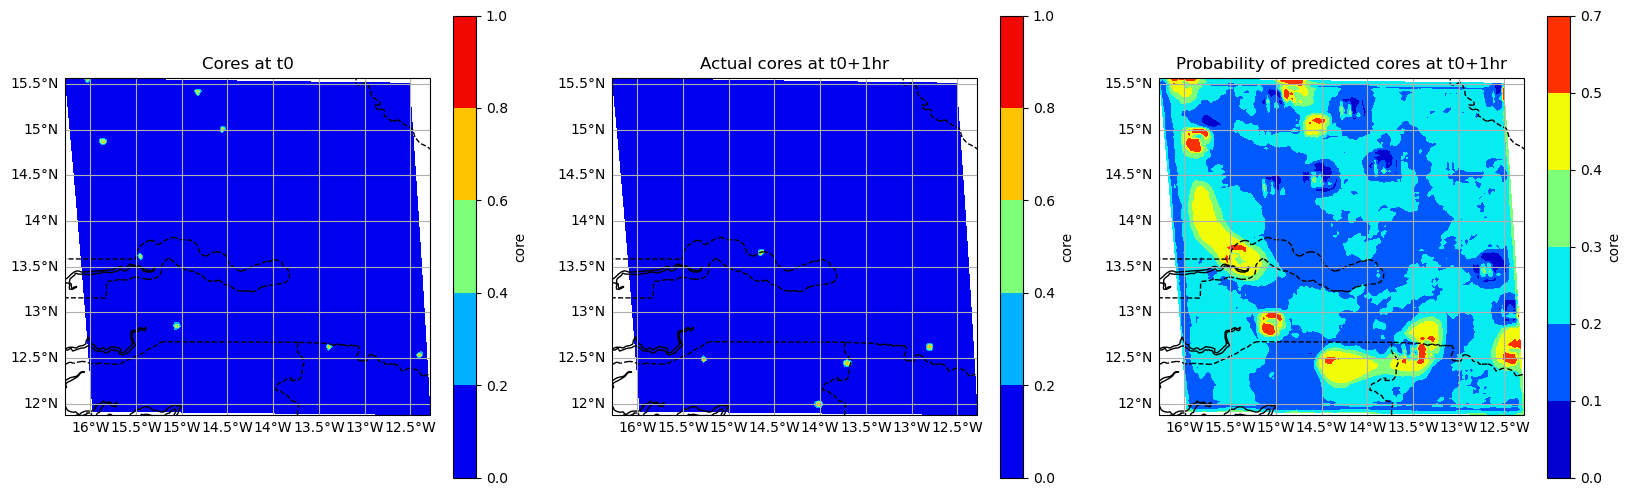

In [177]:
day = 3-2
data = np.zeros((3,image_height,image_width))
#data[0] = np.squeeze(frames[day-4*t0,:,:,0])
data[0] = np.squeeze(frames[day,:,:,0])
data[1] = np.squeeze(original_frames[0,:,:,0])
data[2] = np.squeeze(frames[day+1,:,:,0])
#titles = ['Cores at t0-1hr', 'Cores at t0', 'Probability of cores at t0+1hr']
titles = ['Cores at t0', 'Actual cores at t0+1hr', 'Probability of predicted cores at t0+1hr']
levels_custom=[[0, 0.2, 0.4, 0.6, 0.8,1],[0, 0.2, 0.4, 0.6, 0.8,1],[0, 0.1, 0.2, 0.3, 0.4,0.5,0.7]]#[0, 0.1, 0.2, 0.3,0.4]]

fig, axes = plt.subplots(1, 3, figsize=(20, 6),
                         subplot_kw={'projection':ccrs.PlateCarree()})

i=0
for ax in axes:
    m= ax.contourf(lon[:-a,b:], lat[:-a,b:], data[i], transform=ccrs.PlateCarree(), levels=levels_custom[i],cmap='jet')  # this is the actual plot
# ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(titles[i])
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(m)  # adds colorbar
    cbar.set_label('core')
    i=i+1
 
#plt.show()

In [157]:
def plot_maps(ax, lon, lat, data, title,levels_custom):
    m=ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), levels=levels_custom,cmap='jet')  # this is the actual plot
    ax.coastlines()   ## adds coastlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    #cbar = plt.colorbar(m)  # adds colorbar
    #cbar.set_label('core')


In [158]:
def plot_maps_colorbar(ax, lon, lat, data, title,levels_custom):
    m=ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), levels=levels_custom,cmap='jet')  # this is the actual plot
    ax.coastlines()   ## adds coastlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(m)  # adds colorbar
    cbar.set_label('core')


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility

Predicting core at 15min


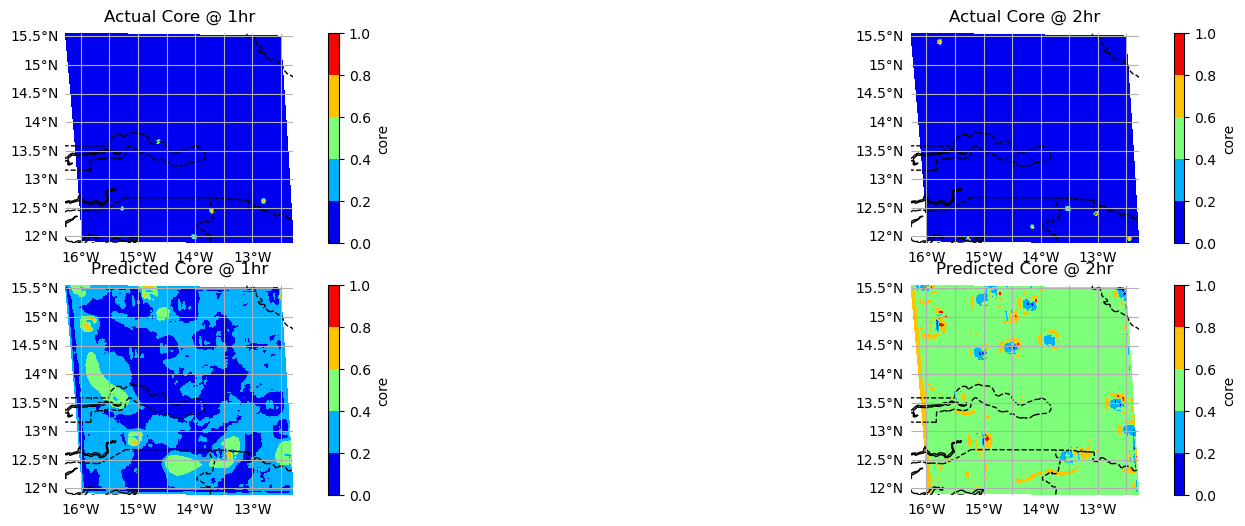

In [178]:
day = 4-2
data = np.zeros((day,image_height,image_width))
for x in range(0,2,1):
    data[x] = np.squeeze(frames[day+x,:,:,0])
        
levels_custom=[[0, 0.2, 0.4, 0.6, 0.8,1],np.arange(0,1.1,0.2)]  #[0, 0.1, 0.2, 0.3,0.4]]
#levels_custom=[[0, 0.5 ,1],[0, 0.5 ,1]]  #[0, 0.1, 0.2, 0.3,0.4]]
    
fig, axes = plt.subplots(2, 2, figsize=(20, 6),
                         subplot_kw={'projection':ccrs.PlateCarree()})

for idx, ax in enumerate(axes[0]):
    plot_maps_colorbar(ax, lon[:-a,b:], lat[:-a,b:], np.squeeze(original_frames[idx,:,:,0]),  title=None ,levels_custom= levels_custom[0])
    ax.set_title(f"Actual Core @ {idx + 1}hr")
    ax.axis("off")

for idx, ax in enumerate(axes[1]):
    plot_maps_colorbar(ax, lon[:-a,b:], lat[:-a,b:], data[idx,:,:],  title=None ,levels_custom= levels_custom[1])
    ax.set_title(f"Predicted Core @ {idx + 1}hr")
    ax.axis("off")

# Print information and display the figure.
print('Predicting core at 15min')
plt.show()